# 1. Imports

In [3]:
!pip install category_encoders
!pip install geopandas
!pip install folium
!pip install geopy
!pip install catboost
!pip install scikit-learn==0.24.2

In [4]:
## Setup external dependencies

import sys
baseline_path = '../baseline'
data_dir = '../../data'
sys.path.append(baseline_path)
print(sys.path)

['/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/location_similarity', '/Users/SamiUrRehman/.vscode/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles', '/Users/SamiUrRehman/.vscode/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles/lib/python', '/usr/local/Cellar/python@3.9/3.9.4/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/usr/local/Cellar/python@3.9/3.9.4/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/usr/local/Cellar/python@3.9/3.9.4/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/SamiUrRehman/Library/Python/3.9/lib/python/site-packages', '/usr/local/lib/python3.9/site-packages', '/usr/local/Cellar/protobuf/3.15.8/libexec/lib/python3.9/site-packages', '/Users/SamiUrRehman/Library/Python/3.9/lib/python/site-packages/IPython/extensions', '/Users/SamiUrRehman/.ipython', '../baseline']


In [5]:
# 1.1. Local imports
# # this is only used when running in sagemer mode
import utils.location_similarity_helper as lsh
import utils.location_similarity_plots as lsp
import utils.location_similarity_cluster as lsc
import utils.location_similarity_train_evaluate as lste
from utils.baseline_helper import create_area_combinations


# 1.2. External imports
import numpy as np
import pandas as pd
import geopandas
import geopy
import json
import matplotlib.pyplot as plt
from shapely import wkt
from sklearn import preprocessing
import pprint
import os

import importlib

importlib.reload(lsp)
importlib.reload(lsh)
importlib.reload(lsc)
importlib.reload(lste)

pd.set_option("display.max_column", 500)

# 2.Load Input Data

In [6]:
sagemaker_mode = False

In [7]:
if sagemaker_mode:
    # get the import
    from setup import load_data_from_s3

    # read data
    bucket_name = "bucket-vwfs-pred-park-global-model-serving-dev"
    file_name = "input/open_data/seattle/train_data_with_trans_100_with_transaction.csv"
    train_data_with_trans_100 = load_data_from_s3(bucket_name, file_name)

else:  # if run locally


    # read the data
    train_data_with_trans_100 = pd.read_csv(
        data_dir + "/train_data_with_trans_100_with_transaction.csv", 
        index_col=0
    )

In [8]:
train_data_with_trans_100

,street_id,observation_interval_start,availability,length,highway,maxspeed,geometry,study_area,hour,weekday,commercial_100,residential_100,transportation_100,schools_100,eventsites_100,restaurant_here_100,shopping_here_100,office_here_100,supermarket_here_100,transportation_here_100,schools_here_100,capacity,hourly_capacity,current_capacity,num_off_street_parking_100,off_street_capa_100,time_key,tempC,windspeedKmph,precipMM,ongoing_trans
0,1262,2019-03-21 08:00:00,0.0,206.470,residential,25.0,"LINESTRING (-122.30894 47.6061773, -122.308940...",Cherry Hill,8,3,45.0,30.0,0.0,0.0,0.0,0,0,1,0,1,0,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,1,25,2019-03-21-08,12,10,0.0,1.0
1,18459,2019-03-21 08:00:00,1.0,99.091,tertiary,25.0,"LINESTRING (-122.30894 47.6061773, -122.309064...",Cherry Hill,8,3,15.0,0.0,0.0,0.0,0.0,0,1,1,2,2,0,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,1,103,2019-03-21-08,12,10,0.0,1.0
2,1257,2019-03-21 08:00:00,1.0,98.755,secondary,25.0,"LINESTRING (-122.3102402 47.6080375, -122.3103...",Cherry Hill,8,3,75.0,105.0,0.0,0.0,0.0,0,0,0,0,0,0,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,1,15,2019-03-21-08,12,10,0.0,0.0
3,1259,2019-03-21 08:00:00,1.0,96.589,secondary,25.0,"LINESTRING (-122.3089518 47.6080341, -122.3096...",Cherry Hill,8,3,60.0,60.0,0.0,0.0,0.0,0,1,0,0,0,0,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,2019-03-21-08,12,10,0.0,1.0
4,1262,2019-03-21 09:00:00,0.0,206.470,residential,25.0,"LINESTRING (-122.30894 47.6061773, -122.308940...",Cherry Hill,9,3,45.0,30.0,0.0,0.0,0.0,0,0,1,0,1,0,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,1,25,2019-03-21-09,13,11,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5852,18065,2019-06-05 19:12:00,1.0,134.269,tertiary,30.0,"LINESTRING (-122.316779 47.6074153, -122.31677...",12th Ave,19,2,20.0,20.0,0.0,0.0,0.0,7,1,0,1,1,0,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,1,6,2019-06-05-19,13,13,0.2,5.0
5853,18065,2019-06-05 20:10:00,1.0,134.269,tertiary,30.0,"LINESTRING (-122.316779 47.6074153, -122.31677...",12th Ave,20,2,20.0,20.0,0.0,0.0,0.0,7,1,0,1,1,0,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,1,6,2019-06-05-20,12,10,0.0,0.0
5854,18065,2019-06-05 21:15:00,1.0,134.269,tertiary,30.0,"LINESTRING (-122.316779 47.6074153, -122.31677...",12th Ave,21,2,20.0,20.0,0.0,0.0,0.0,7,1,0,1,1,0,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,1,6,2019-06-05-21,10,7,0.0,0.0
5855,18065,2019-06-05 22:12:00,1.0,134.269,tertiary,30.0,"LINESTRING (-122.316779 47.6074153, -122.31677...",12th Ave,22,2,20.0,20.0,0.0,0.0,0.0,7,1,0,1,1,0,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,1,6,2019-06-05-22,10,8,0.0,0.0


# 3. Filter input data

As we proved in baseline, that there are 17 areas in total but only 9 areas has a record over 250, and the rest areas are quite spreaded, therefore, we filtered out only the 9 areas

In [9]:
# Filter data for selected areas
selected_areas = [
    "Greenlake",
    "South Lake Union",
    "Commercial Core",
    "Pike-Pine",
    "Uptown",
    "Ballard",
    "First Hill",
    "Chinatown/ID",
    "Pioneer Square",
]
train_data_with_trans_100_filtered = train_data_with_trans_100[
    train_data_with_trans_100["study_area"].isin(selected_areas)
]

street_count = len(train_data_with_trans_100_filtered.street_id.unique())
raw_street_count_unique = len(train_data_with_trans_100.street_id.unique())
print(f"Filtered Data Shape: {train_data_with_trans_100_filtered.shape}")
print(f"Training data has {street_count} streets")
print(
    f"Original Data without filtering has {raw_street_count_unique} unique streets (ground truth)"
)

Filtered Data Shape: (5427, 31)
Training data has 393 streets
Original Data without filtering has 427 unique streets (ground truth)


In [10]:
train_data_with_trans_100_filtered

,street_id,observation_interval_start,availability,length,highway,maxspeed,geometry,study_area,hour,weekday,commercial_100,residential_100,transportation_100,schools_100,eventsites_100,restaurant_here_100,shopping_here_100,office_here_100,supermarket_here_100,transportation_here_100,schools_here_100,capacity,hourly_capacity,current_capacity,num_off_street_parking_100,off_street_capa_100,time_key,tempC,windspeedKmph,precipMM,ongoing_trans
205,8671,2019-04-04 08:04:00,1.0,68.835,secondary,25.0,"LINESTRING (-122.3261643 47.6789845, -122.3262...",Greenlake,8,3,128.0,0.0,0.0,0.0,0.0,3,0,0,0,1,0,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,1,20,2019-04-04-08,14,3,0.0,1.0
206,7390,2019-04-04 08:13:00,1.0,58.163,secondary,25.0,"LINESTRING (-122.3282649 47.6783132, -122.3280...",Greenlake,8,3,160.0,64.0,0.0,0.0,0.0,2,0,1,0,2,0,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,1,20,2019-04-04-08,14,3,0.0,0.0
207,23879,2019-04-04 08:25:00,0.0,181.089,secondary,35.0,"LINESTRING (-122.3406668 47.6286046, -122.3405...",South Lake Union,8,3,33.0,11.0,0.0,0.0,0.0,2,0,0,0,0,0,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,1,139,2019-04-04-08,14,3,0.0,3.0
208,21688,2019-04-04 08:26:00,0.0,78.891,tertiary,25.0,"LINESTRING (-122.3245469 47.6798127, -122.3245...",Greenlake,8,3,160.0,64.0,0.0,0.0,0.0,14,4,0,2,1,3,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,1,186,2019-04-04-08,14,3,0.0,2.0
209,16023,2019-04-04 08:27:00,1.0,81.134,tertiary,25.0,"LINESTRING (-122.324689 47.6805157, -122.32492...",Greenlake,8,3,35.0,28.0,0.0,0.0,0.0,12,3,0,0,1,3,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,2,206,2019-04-04-08,14,3,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5842,980,2019-06-01 22:19:00,1.0,97.326,tertiary,25.0,"LINESTRING (-122.3364381 47.6065823, -122.3365...",Commercial Core,22,5,60.0,30.0,0.0,0.0,0.0,12,15,5,3,3,0,67,"{'0': 2, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,5,771,2019-06-01-22,14,5,0.0,0.0
5843,19356,2019-06-01 22:21:00,1.0,98.617,tertiary,25.0,"LINESTRING (-122.3368912 47.6087555, -122.3370...",Commercial Core,22,5,30.0,60.0,0.0,0.0,0.0,9,8,2,3,5,0,14,"{'0': 9, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,4,1062,2019-06-01-22,14,5,0.0,0.0
5844,17924,2019-06-01 22:27:00,0.0,58.121,primary,25.0,"LINESTRING (-122.339962 47.6113492, -122.34001...",Commercial Core,22,5,180.0,240.0,0.0,0.0,0.0,11,4,1,1,3,0,24,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,2,1409,2019-06-01-22,14,5,0.0,0.0
5845,13357,2019-06-01 22:29:00,0.0,129.517,secondary,25.0,"LINESTRING (-122.3390905 47.607833, -122.33903...",Commercial Core,22,5,30.0,60.0,0.0,0.0,0.0,20,13,3,2,1,0,33,"{'0': 13, '1': 0, '2': 0, '3': 0, '4': 0, '5':...",0,2,244,2019-06-01-22,14,5,0.0,0.0


# 4. Create Street as Similarity Entity - Calculate Distance Between Street Vectors

    1. Goal: understand the similarity of all the streets in seattle based on its vector representation, define the similarity between streets
    2. Below steps have been included in this section:

        1)Process the data
        2)compute the distance(cosine, euclinean)
        3)correlate output of the previous, correlate euclinean/cosine withh real geo distance
        4)analyze if they are really correlated

## 4.1 Preprocess Data

In [11]:
train_data_with_trans_100.columns

Index(['street_id', 'observation_interval_start', 'availability', 'length',
       'highway', 'maxspeed', 'geometry', 'study_area', 'hour', 'weekday',
       'commercial_100', 'residential_100', 'transportation_100',
       'schools_100', 'eventsites_100', 'restaurant_here_100',
       'shopping_here_100', 'office_here_100', 'supermarket_here_100',
       'transportation_here_100', 'schools_here_100', 'capacity',
       'hourly_capacity', 'current_capacity', 'num_off_street_parking_100',
       'off_street_capa_100', 'time_key', 'tempC', 'windspeedKmph', 'precipMM',
       'ongoing_trans'],
      dtype='object')

hour, weekday, current_capacity, tempC, windspeedKmph, precipMM - we did not include for it to calculate the street similarity as they are time dependent

In [12]:
# create data
# hour, weekday, current_capacity, tempC, windspeedKmph, precipMM - we did not include for it to calculate the street similarity as they are time dependent
selected_features = [
    "street_id",  # note this is not as feature, but just needed to be selected
    "availability",  # note this is not as feature, but just needed to be selected
    "length",
    "highway",
    "maxspeed",  # input but not used for clustering
    "commercial_100",
    "residential_100",
    "transportation_100",
    "schools_100",
    "eventsites_100",
    "geometry",  # note this is not as feature, but just needed to be selected
    "restaurant_here_100",
    "shopping_here_100",
    "office_here_100",
    "supermarket_here_100",
    "transportation_here_100",
    "schools_here_100",
    "num_off_street_parking_100",
    "off_street_capa_100",
    "ongoing_trans",
]
# preprocess the data, here we use the df_similarity_features as basis to cluster the streets based on their vector
# similarity
(
    df_features,
    df_similarity_features,
    _,
    df_geometry,
) = lsh.preprocess_for_similarity_analysis(
    train_data_with_trans_100_filtered,
    selected_features,
    options={
        "impute_maxspeed": False,  # not use maxspeed when clustering
        "encode_highway": True,  # use highway when clustering
        "time_dependant_features": None,  # we decide not to use time_depedent feature when clustering
    },
)

# only take the unique streets, currently cluster only based on streets
df_similarity_features["street_id"] = df_similarity_features.index
df_similarity_features.drop_duplicates(subset=["street_id"], inplace=True)
df_similarity_features.drop(["street_id"], axis=1, inplace=True)
df_geometry = df_geometry.drop_duplicates(subset=["street_id"]).set_index("street_id")

/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [13]:
df_features.head(1)

,availability,length,highway,maxspeed,commercial_100,residential_100,transportation_100,schools_100,eventsites_100,geometry,restaurant_here_100,shopping_here_100,office_here_100,supermarket_here_100,transportation_here_100,schools_here_100,num_off_street_parking_100,off_street_capa_100,ongoing_trans
street_id,,,,,,,,,,,,,,,,,,,
8671,1.0,68.835,secondary,25.0,128.0,0.0,0.0,0.0,0.0,"LINESTRING (-122.3261643 47.6789845, -122.3262...",3,0,0,0,1,0,1,20,1.0


In [14]:
# drop on-going transaction, as it is also time dependent feature, we do not need time-dependent feature when we have on-going trans
df_similarity_features.drop(["ongoing_trans"], axis=1, inplace=True)

In [15]:
df_similarity_features.head(1)

,length,highway,commercial_100,residential_100,transportation_100,schools_100,eventsites_100,restaurant_here_100,shopping_here_100,office_here_100,supermarket_here_100,transportation_here_100,schools_here_100,num_off_street_parking_100,off_street_capa_100
street_id,,,,,,,,,,,,,,,
8671,68.835,0.647145,128.0,0.0,0.0,0.0,0.0,3,0,0,0,1,0,1,20


In [16]:
print(
    f"We have used {len(df_similarity_features.columns)} features to cluster the {len(df_similarity_features)} streets."
)

We have used 15 features to cluster the 393 streets.


In [17]:
df_geometry.head(1)

,geometry
street_id,
8671,"LINESTRING (-122.3261643 47.6789845, -122.3262..."


In [18]:
# lsp.plot_highway(df_features)

## 4.2 Compute the pairwise distance(euclinean, cosine) of the streets based on feature vector
hereby we are normalizing the feature:

    1)so within each feature, they have the same variation
    2)different features have different variation
    3)(in which case, we keep the different magnitude of the different features, namely preserved the distribution between features)

### 4.2.1 Use l2 to normalize features(columns)

To calculate the distance between the vectors, we firstly need to normalize the vectors, multiple ways are possible, and we would use L2 below to firstly normalize and then use euclidean to calculate the distance, therefore, we try out different ways and determine a way which could distinguish the streets more.

In [19]:
df_similarity_features

,length,highway,commercial_100,residential_100,transportation_100,schools_100,eventsites_100,restaurant_here_100,shopping_here_100,office_here_100,supermarket_here_100,transportation_here_100,schools_here_100,num_off_street_parking_100,off_street_capa_100
street_id,,,,,,,,,,,,,,,
8671,68.835,0.647145,128.0,0.0,0.0,0.0,0.0,3,0,0,0,1,0,1,20
7390,58.163,0.647145,160.0,64.0,0.0,0.0,0.0,2,0,1,0,2,0,1,20
23879,181.089,0.647145,33.0,11.0,0.0,0.0,0.0,2,0,0,0,0,0,1,139
21688,78.891,0.621996,160.0,64.0,0.0,0.0,0.0,14,4,0,2,1,3,1,186
16023,81.134,0.621996,35.0,28.0,0.0,0.0,0.0,12,3,0,0,1,3,2,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,55.320,0.605150,0.0,8.0,4.0,0.0,0.0,3,6,0,0,8,0,3,64
21959,66.194,0.621996,2.0,2.0,0.0,0.0,0.0,11,16,3,2,0,0,1,77
23270,93.929,0.647145,11.0,22.0,0.0,0.0,0.0,29,17,1,2,1,0,0,0


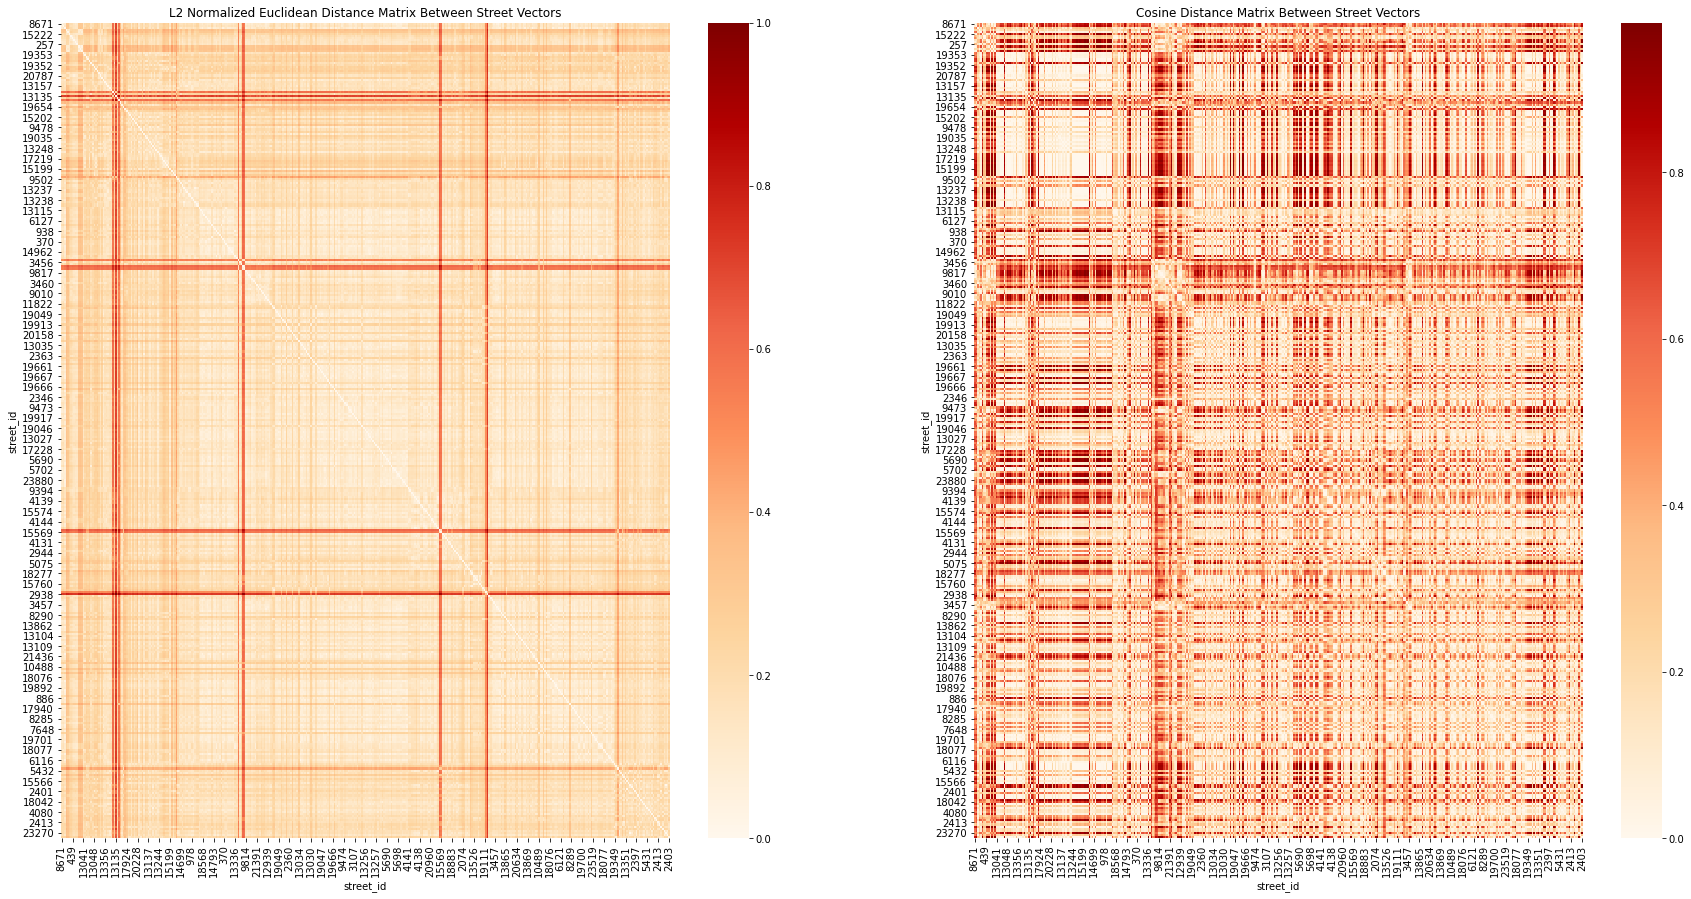

In [20]:
# compute pairwise distance
# for euclinean distance -normalize first, normalize the features NOT the rows
similarity_features_l2_normalized = preprocessing.normalize(
    df_similarity_features, norm="l2", axis=0
)

df_similarity_features_l2_normalized = pd.DataFrame(
    similarity_features_l2_normalized,
    index=df_similarity_features.index,
    columns=df_similarity_features.columns,
)

# call the distance function
df_pair_dist_l2_normalized = lsh.street_pairwise_dist(
    df_similarity_features_l2_normalized, "euclidean"
)
df_pair_cosine = lsh.street_pairwise_dist(df_similarity_features, "cosine")

# normalize enclinean distance matrix, so that it is on same scale[0, 1] with cosine to be able to compare better with correlation plot

df_pair_dist_l2_normalized_scaled = lsh.scale_before_plot_correlation(
    df_pair_dist_l2_normalized
)

# plot all the streets for both l2 normalized and cosine normalized distance
# the lighhter the color, the less distant, the more similar they are
lsp.plot_distance_matrix(
    df_pair_dist_l2_normalized_scaled,
    df_pair_cosine,
    len(df_similarity_features),
    "L2 Normalized Euclidean Distance Matrix Between Street Vectors",
    "Cosine Distance Matrix Between Street Vectors",
)

### 4.2.2 Use min max to normalize features(columns)

Use min-max normalizer first before calculate the euclidean distance

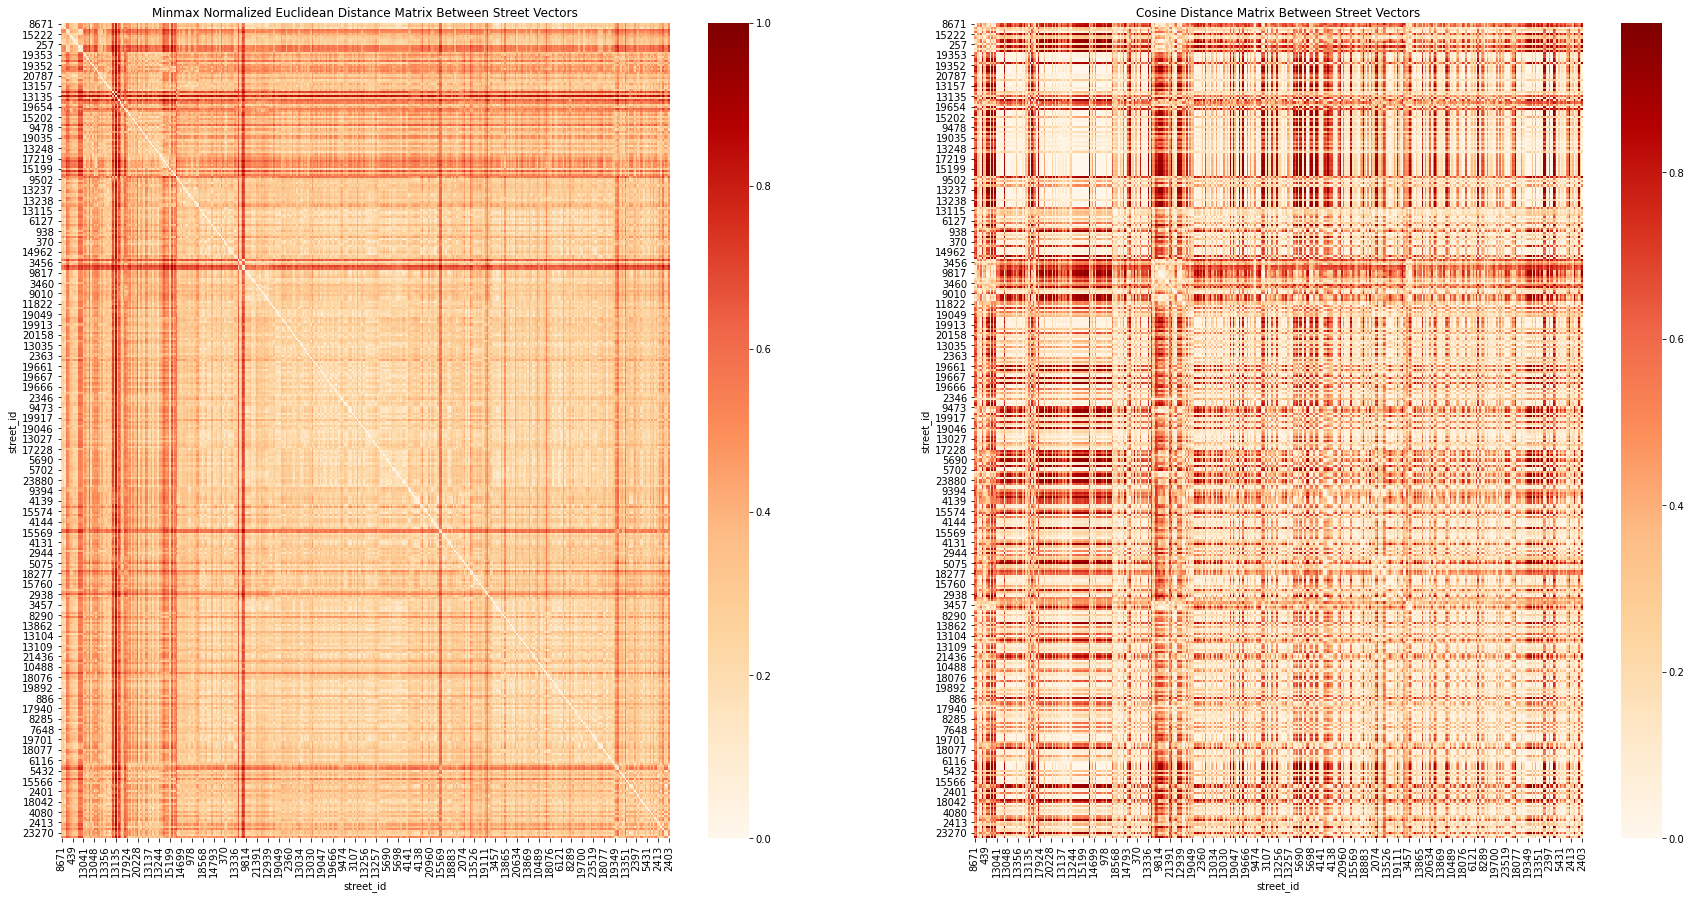

In [21]:
# use min max scaler
similarity_features_max_normalized = preprocessing.normalize(
    df_similarity_features, norm="max", axis=0
)

df_similarity_features_max_normalized = pd.DataFrame(
    similarity_features_max_normalized,
    index=df_similarity_features.index,
    columns=df_similarity_features.columns,
)
# get the euclinean distance
df_pair_dist_max_normalized = lsh.street_pairwise_dist(
    df_similarity_features_max_normalized, "euclidean"
)

# get the scaled euclinean distance, range[0,1]
df_pair_dist_max_normalized_scaled = lsh.scale_before_plot_correlation(
    df_pair_dist_max_normalized
)

lsp.plot_distance_matrix(
    df_pair_dist_max_normalized_scaled,
    df_pair_cosine,
    len(df_similarity_features),
    "Minmax Normalized Euclidean Distance Matrix Between Street Vectors",
    "Cosine Distance Matrix Between Street Vectors",
)


**Conclusion: the darker the color, the more 'distant' are the streets, thus they would be more distinguishable, and therefore minmax normalized euclindean distance can distinguish the streets more**

## 4.3 Compute the pairwise distance of the streets based on geometry

Another way to think about the distance betweent the streets are of course the geographical distance, and hereby we use the centroid of the lines as the geometry of the streets and calculate the pairwised geographical distance between the streets.

In [22]:
# get the centroid
df_geometry["geometry"] = df_geometry["geometry"].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df_geometry, geometry=df_geometry["geometry"])
gdf["line_centroid"] = gdf["geometry"].centroid
gdf.head()

,geometry,line_centroid
street_id,,
8671,"LINESTRING (-122.32616 47.67898, -122.32624 47...",POINT (-122.32648 47.67875)
7390,"LINESTRING (-122.32826 47.67831, -122.32804 47...",POINT (-122.32788 47.67833)
23879,"LINESTRING (-122.34067 47.62860, -122.34059 47...",POINT (-122.34016 47.62787)
21688,"LINESTRING (-122.32455 47.67981, -122.32456 47...",POINT (-122.32462 47.68016)
16023,"LINESTRING (-122.32469 47.68052, -122.32492 47...",POINT (-122.32492 47.68085)


In [23]:
result = lsh.calculate_street_similarity_matrix(gdf)
df_real_dist = pd.DataFrame(data=result)
# df_real_dist.to_csv('df_real_dist.csv')
# df_real_dist = pd.read_csv('df_real_dist.csv', index_col=0)

total time taken this loop:  126.36199808120728


## 4.4 Correlate the distances calculated above

The goal of this part is to decide which distance metrics to use to calculate the similarity based either on feature vectors of the streets or geometry of the streets, therefore, we correlated the below combinations:
1) L2 normalized euclinean distance
2) max normalized euclinean distance
3) cosine distance respectively with the actual geo distance

### 4.4.1 Correlation between two distance metrics (euclinean and cosine)

##### Correlate l2 normalized euclidean and cosine distance

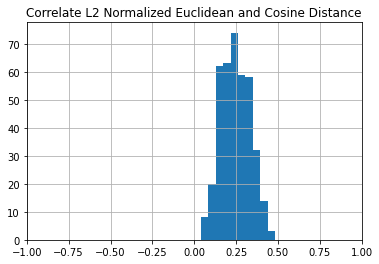

In [24]:
corr_l2euclinean_cosine = df_pair_dist_l2_normalized.corrwith(df_pair_cosine, axis=0)
lsp.plot_correlation_distance(
    corr_l2euclinean_cosine, "Correlate L2 Normalized Euclidean and Cosine Distance"
)

##### Correlate Minmax normalized euclidean and cosine distance

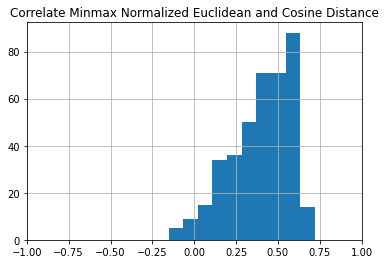

In [25]:
corr_maxeuclinean_cosine = df_pair_dist_max_normalized.corrwith(df_pair_cosine, axis=0)

lsp.plot_correlation_distance(
    corr_maxeuclinean_cosine,
    "Correlate Minmax Normalized Euclidean and Cosine Distance",
)

### 4.4.2 Correlation between the l2 or max normalized euclinean distance with the real geo distance

In [26]:
df_real_dist.index = df_real_dist.index.astype("int64", False)
df_real_dist.columns = df_real_dist.columns.astype("int64", False)

##### Correlate l2 normalized euclidean distance and real geo distance

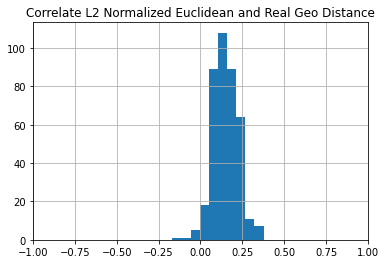

In [27]:
corr_l2euclinean_realdist = df_pair_dist_l2_normalized.corrwith(df_real_dist, axis=0)
lsp.plot_correlation_distance(
    corr_l2euclinean_realdist, "Correlate L2 Normalized Euclidean and Real Geo Distance"
)

##### Correlate min max normalized euclidean distance and real geo distance

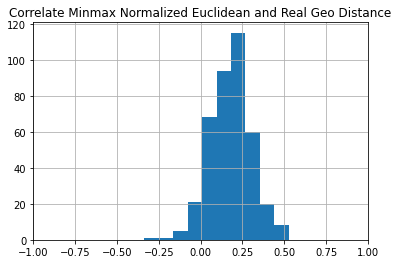

In [28]:
corr_maxeuclinean_realdist = df_pair_dist_max_normalized.corrwith(
    pd.DataFrame(df_real_dist), axis=0
)
lsp.plot_correlation_distance(
    corr_maxeuclinean_realdist,
    "Correlate Minmax Normalized Euclidean and Real Geo Distance",
)

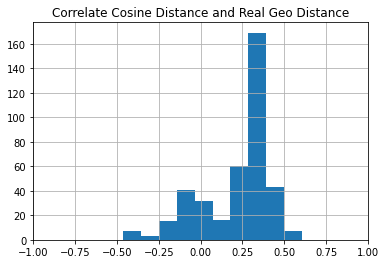

In [29]:
corr_cosindist_realdist = df_pair_cosine.corrwith(pd.DataFrame(df_real_dist), axis=0)
lsp.plot_correlation_distance(
    corr_cosindist_realdist, "Correlate Cosine Distance and Real Geo Distance"
)

**Conclusion: based on above graphs, we choose the method which correlated mostly to the real geographica distance, therefore, we decided to use min-max normalized Euclidean distance as street similarity distance metric.**

# 5. Create Clusters as Similarity Entity

After creating streets as similarity entity, we now cluster those streets, to generate similarity clusters, which is representive. We have chose several clustering algortims and also initializing the clustering two process for source and target areas separately.

1. use min max normalized euclinean distance to normalize street vectors(based on above analysis)
2. for each area combination:
        for each type of similarity measurement (either GPS or vector similairity)
            cluster data based on different clustering algorithm(either kmeans of ag

## 5.1 Plot the Data Points

In [30]:
df_geometry["lon"] = df_geometry.line_centroid.apply(lambda p: p.x)
df_geometry["lat"] = df_geometry.line_centroid.apply(lambda p: p.y)

df_geometry.head()

,geometry,line_centroid,lon,lat
street_id,,,,
8671,"LINESTRING (-122.32616 47.67898, -122.32624 47...",POINT (-122.32648 47.67875),-122.326478,47.678750
7390,"LINESTRING (-122.32826 47.67831, -122.32804 47...",POINT (-122.32788 47.67833),-122.327879,47.678334
23879,"LINESTRING (-122.34067 47.62860, -122.34059 47...",POINT (-122.34016 47.62787),-122.340162,47.627873
21688,"LINESTRING (-122.32455 47.67981, -122.32456 47...",POINT (-122.32462 47.68016),-122.324618,47.680164
16023,"LINESTRING (-122.32469 47.68052, -122.32492 47...",POINT (-122.32492 47.68085),-122.324922,47.680845


In [31]:
# get city coordinates

city = "Seattle"
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location_seattle = locator.geocode(city)

location_seattle = [location_seattle.latitude, location_seattle.longitude]
print("[lat, long]:", location_seattle)

# map to plot the area
df_street_coords = df_geometry[["lon", "lat"]]
df_study_area = (
    train_data_with_trans_100_filtered[["street_id", "study_area"]]
    .drop_duplicates()
    .set_index("street_id")
)
street_coords_study_area = pd.merge(
    df_street_coords, df_study_area, left_index=True, right_index=True
)

street_coords_study_area["study_area"] = street_coords_study_area["study_area"].map(
    {
        "Pike-Pine": 0,
        "First Hill": 1,
        "South Lake Union": 2,
        "Commercial Core": 3,
        "Ballard": 4,
        "Chinatown/ID": 5,
        "Greenlake": 6,
        "Pioneer Square": 7,
        "University District": 8,
        "Uptown": 9,  #
        "Uptown Triangle": 10,
        "Capitol Hill": 11,
        "University District": 12,
        "12th Ave": 13,
        "Fremont": 14,
        "Cherry Hill": 15,
        "Ballard Locks": 16,
        "Roosevelt": 17,
        "Westlake": 18,
        "Columbia City": 19,
    }
)

# plot the map where shows the 4 districts of Seattle, the output html is called map
# lsp.plot_cluster_folium(
#    data=street_coords_study_area,
#    study_area='study_area',
#    tiles='OpenStreetMap'
# )

[lat, long]: [47.6038321, -122.3300624]


In [32]:
train_data_with_trans_100_filtered.study_area.unique()

array(['Greenlake', 'South Lake Union', 'Commercial Core', 'Pike-Pine',
       'Uptown', 'Ballard', 'First Hill', 'Chinatown/ID',
       'Pioneer Square'], dtype=object)

In [33]:
print(
    f"There are {len(street_coords_study_area.study_area.unique())} unique areas in seattle after filtering out areas with small number of data"
)

There are 9 unique areas in seattle after filtering out areas with small number of data


## 5.2 Clustering

In this section, we cluster the street based on the vector similairity(the triangular matrix of the vector distance) and also on GPS(based on the geometry of the streets)

    1)we split the data into train and test, and initialize clustering process for train and test separately
    2)we tried out 3 clustering algorithms to generate cluster in result

The output is expected to be:

    for each street, there is a number of clustering labels generated by using different clustering algorithms and different street similarity(either GPS or vector similarity)

We have refered to below materials to determine the clustering algorithms:

    https://datascience.stackexchange.com/questions/761/clustering-geo-location-coordinates-lat-long-pairs
    https://community.dataiku.com/t5/Using-Dataiku-DSS/How-to-cluster-geo-points-according-to-their-pairwise-distances/m-p/2931
    https://datascience.stackexchange.com/questions/761/clustering-geo-location-coordinates-lat-long-pairs

### 5.2.1 Prepare the clustering data

In [34]:
# for GPS, we also need to divide by the km_per_radian

km_per_radian = 6371.0088

In [35]:
df_street_coords = pd.merge(
    df_street_coords, df_study_area, left_index=True, right_index=True
)

In [36]:
df_street_coords

,lon,lat,study_area
street_id,,,
8671,-122.326478,47.678750,Greenlake
7390,-122.327879,47.678334,Greenlake
23879,-122.340162,47.627873,South Lake Union
21688,-122.324618,47.680164,Greenlake
16023,-122.324922,47.680845,Greenlake
...,...,...,...
2408,-122.330275,47.601472,Pioneer Square
21959,-122.333688,47.598310,Pioneer Square
23270,-122.334129,47.601314,Pioneer Square


In [37]:
# split train and test area to prepare for clustering

all_area_combinations = create_area_combinations(selected_areas)

"""
area_input_data:
    - first key: area_for_train
        - second key: Source, Target
        - second key value: dataframe with streets data inside
"""
area_input_data = {}
for area_combination in all_area_combinations:
    area_name = area_combination["Target"][0]
    area_input_data[area_name] = {}
    area_input_data[area_name]["Target"] = df_street_coords[
        df_street_coords.study_area == area_name
    ]
    train_street_coords_temp = []
    for source_area in area_combination["Source"]:
        train_street_coords_temp.append(
            df_street_coords[df_street_coords.study_area == source_area]
        )
    area_input_data[area_name]["Source"] = pd.concat(train_street_coords_temp)

### 5.2.2 Call Clustering Function & Create Cluster Result

In [38]:
"""
Loop through different similairty metrics: either sim (represents street vector similairy) or gps(represents GPS coordinates)
    loop through the train and test data set(as we have seperate clustering process)
        loop through different clustering algorithm
"""

# Loop through different similairty metrics
for i, area_name in enumerate(area_input_data.keys()):
    print(i, "====== area_name:", area_name)
    for base in ["sim", "gps"]:
        # loop through the train and test data set, in the end append the cluster label back to them
        for i, data in enumerate(
            [
                area_input_data[area_name]["Source"],
                area_input_data[area_name]["Target"],
            ]
        ):
            is_train = i == 0  # check if it is data is training data or not
            #            for algorithm in ['db_scan', 'kmeans', 'agg_clustering']:
            for algorithm in ["kmeans", "agg_clustering"]:
                label = (
                    algorithm + "_label_" + base
                )  # the name of the label(clustering algo + label + similarity metrics)
                print("performing cluster labeling for", label, is_train)
                # call the clustering algorithm to generate cluster labels
                cluster_data = lsh.create_cluster_label(
                    area_input_data,
                    df_pair_dist_max_normalized,
                    area_name,
                    base,
                    algorithm,
                    data,
                    is_train,
                )
                # append the label back to its dataframe
                data[label] = cluster_data

                # number of streets in each cluster
                result_size = data.groupby(label).size()
                print(f"The group result of {result_size}")

                # DB scan we need to check the number of outliers
                if algorithm == "db_scan":
                    outlier_count = len(data[data[label] == -1])
                    outlier_percentage = outlier_count / len(result_size) * 100
                    print(
                        f"Percentage of data points which has been clustered as outliers: {outlier_percentage}%"
                    )

                # plot the data with folium
                lsp.plot_cluster_folium(data=data, cluster_label=label, train=is_train)
print("DONE!")

0 ====== area_name: Greenlake
performing cluster labeling for kmeans_label_sim True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 380 points down to 15 clusters, for 96.1% compression in 0.13 seconds
Silhouette coefficient: 0.194
The group result of kmeans_label_sim
0     21
1     29
2      6
3     34
4     42
5      7
6     16
7     22
8     20
9     10
10    34
11    65
12    53
13     7
14    14
dtype: int64
performing cluster labeling for agg_clustering_label_sim True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  

/usr/local/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


performing cluster labeling for kmeans_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of kmeans_label_sim
-1    13
dtype: int64


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of agg_clustering_label_sim
-1    13
dtype: int64
performing cluster labeling for kmeans_label_gps True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 380 points down to 15 clusters, for 96.1% compression in 0.08 seconds
Silhouette coefficient: 0.442
The group result of kmeans_label_gps
0     25
1     37
2    

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_gps False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of agg_clustering_label_gps
-1    13
dtype: int64
1 ====== area_name: South Lake Union
performing cluster labeling for kmeans_label_sim True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 300 points down to 12 clusters, for 96.0% compression in 0.11 seconds
Silhouette coefficient: 0.186
The group result of kme

/usr/local/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


performing cluster labeling for kmeans_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 93 points down to 4 clusters, for 95.7% compression in 0.03 seconds
Silhouette coefficient: 0.272
The group result of kmeans_label_sim
0    26
1     9
2    42
3    16
dtype: int64


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 93 points down to 4 clusters, for 95.7% compression in 0.01 seconds
Silhouette coefficient: 0.297
The group result of agg_clustering_label_sim
0    57
1    15
2     7
3    14
dtype: int64


/usr/local/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for kmeans_label_gps True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 300 points down to 12 clusters, for 96.0% compression in 0.06 seconds
Silhouette coefficient: 0.505
The group result of kmeans_label_gps
0     29
1     25
2     32
3     13
4     25
5     31
6     42
7     29
8     13
9      7
10    37
11    17
dtype: int64
performing cluster labeling for agg_clustering_label_gps True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer S

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_gps False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 93 points down to 4 clusters, for 95.7% compression in 0.00 seconds
Silhouette coefficient: 0.388
The group result of agg_clustering_label_gps
0    39
1    25
2    22
3     7
dtype: int64


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


2 ====== area_name: Commercial Core
performing cluster labeling for kmeans_label_sim True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 318 points down to 13 clusters, for 95.9% compression in 0.15 seconds
Silhouette coefficient: 0.192
The group result of kmeans_label_sim
0     30
1      9
2     46
3     46
4     58
5      5
6     11
7     27
8      6
9     52
10    16
11     8
12     4
dtype: int64
performing cluster labeling for agg_clustering_label_sim True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
C

/usr/local/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


performing cluster labeling for kmeans_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 75 points down to 3 clusters, for 96.0% compression in 0.02 seconds
Silhouette coefficient: 0.304
The group result of kmeans_label_sim
0    52
1     5
2    18
dtype: int64


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 75 points down to 3 clusters, for 96.0% compression in 0.01 seconds
Silhouette coefficient: 0.301
The group result of agg_clustering_label_sim
0    55
1     5
2    15
dtype: int64


/usr/local/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for kmeans_label_gps True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 318 points down to 13 clusters, for 95.9% compression in 0.09 seconds
Silhouette coefficient: 0.515
The group result of kmeans_label_gps
0     33
1     25
2     13
3     30
4     25
5     29
6     36
7     28
8     23
9      9
10    37
11     7
12    23
dtype: int64
performing cluster labeling for agg_clustering_label_gps True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_gps False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 75 points down to 3 clusters, for 96.0% compression in 0.00 seconds
Silhouette coefficient: 0.393
The group result of agg_clustering_label_gps
0    32
1    28
2    15
dtype: int64


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


3 ====== area_name: Pike-Pine
performing cluster labeling for kmeans_label_sim True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 367 points down to 15 clusters, for 95.9% compression in 0.11 seconds
Silhouette coefficient: 0.190
The group result of kmeans_label_sim
0     34
1     28
2      8
3     55
4     36
5     18
6     20
7      8
8     39
9     13
10    52
11     5
12    13
13    16
14    22
dtype: int64
performing cluster labeling for agg_clustering_label_sim True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  

/usr/local/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


performing cluster labeling for kmeans_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of kmeans_label_sim
-1    26
dtype: int64


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of agg_clustering_label_sim
-1    26
dtype: int64
performing cluster labeling for kmeans_label_gps True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 367 points down to 15 clusters, for 95.9% compression in 0.07 seconds
Silhouette coefficient: 0.460
The group result of kmeans_label_gps
0     34
1     25
2    

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_gps False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of agg_clustering_label_gps
-1    26
dtype: int64
4 ====== area_name: Uptown
performing cluster labeling for kmeans_label_sim True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 368 points down to 15 clusters, for 95.9% compression in 0.17 seconds
Silhouette coefficient: 0.198
The group result of kmeans_label_

/usr/local/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


performing cluster labeling for kmeans_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of kmeans_label_sim
-1    25
dtype: int64


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of agg_clustering_label_sim
-1    25
dtype: int64
performing cluster labeling for kmeans_label_gps True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 368 points down to 15 clusters, for 95.9% compression in 0.09 seconds
Silhouette coefficient: 0.454
The group result of kmeans_label_gps
0     33
1     25
2    

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_gps False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of agg_clustering_label_gps
-1    25
dtype: int64
5 ====== area_name: Ballard
performing cluster labeling for kmeans_label_sim True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 368 points down to 15 clusters, for 95.9% compression in 0.19 seconds
Silhouette coefficient: 0.198
The group result of kmeans_label

/usr/local/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


performing cluster labeling for kmeans_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of kmeans_label_sim
-1    25
dtype: int64


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of agg_clustering_label_sim
-1    25
dtype: int64
performing cluster labeling for kmeans_label_gps True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 368 points down to 15 clusters, for 95.9% compression in 0.13 seconds
Silhouette coefficient: 0.446
The group result of kmeans_label_gps
0     26
1     36
2    

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_gps False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of agg_clustering_label_gps
-1    25
dtype: int64
6 ====== area_name: First Hill
performing cluster labeling for kmeans_label_sim True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 323 points down to 13 clusters, for 96.0% compression in 0.09 seconds
Silhouette coefficient: 0.206
The group result of kmeans_la

/usr/local/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


performing cluster labeling for kmeans_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 70 points down to 3 clusters, for 95.7% compression in 0.04 seconds
Silhouette coefficient: 0.271
The group result of kmeans_label_sim
0    16
1    29
2    25
dtype: int64


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 70 points down to 3 clusters, for 95.7% compression in 0.00 seconds
Silhouette coefficient: 0.245
The group result of agg_clustering_label_sim
0    24
1    15
2    31
dtype: int64


/usr/local/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for kmeans_label_gps True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 323 points down to 13 clusters, for 96.0% compression in 0.06 seconds
Silhouette coefficient: 0.492
The group result of kmeans_label_gps
0     13
1     40
2     25
3     23
4     33
5     21
6     25
7     18
8     34
9     10
10    21
11    32
12    28
dtype: int64
performing cluster labeling for agg_clustering_label_gps True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_gps False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 70 points down to 3 clusters, for 95.7% compression in 0.00 seconds
Silhouette coefficient: 0.358
The group result of agg_clustering_label_gps
0    35
1    23
2    12
dtype: int64


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


7 ====== area_name: Chinatown/ID
performing cluster labeling for kmeans_label_sim True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 363 points down to 15 clusters, for 95.9% compression in 0.11 seconds
Silhouette coefficient: 0.201
The group result of kmeans_label_sim
0     25
1     18
2     57
3     36
4     10
5     25
6     23
7     57
8     12
9      1
10     5
11    35
12    17
13     6
14    36
dtype: int64
performing cluster labeling for agg_clustering_label_sim True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 32

/usr/local/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


performing cluster labeling for kmeans_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of kmeans_label_sim
-1    30
dtype: int64


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of agg_clustering_label_sim
-1    30
dtype: int64
performing cluster labeling for kmeans_label_gps True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 363 points down to 15 clusters, for 95.9% compression in 0.07 seconds
Silhouette coefficient: 0.456
The group result of kmeans_label_gps
0     35
1     25
2    

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_gps False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of agg_clustering_label_gps
-1    30
dtype: int64
8 ====== area_name: Pioneer Square
performing cluster labeling for kmeans_label_sim True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 357 points down to 14 clusters, for 96.1% compression in 0.10 seconds
Silhouette coefficient: 0.198
The group result of kmean

/usr/local/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


performing cluster labeling for kmeans_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of kmeans_label_sim
-1    36
dtype: int64


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_sim False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of agg_clustering_label_sim
-1    36
dtype: int64
performing cluster labeling for kmeans_label_gps True
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
Clustered 357 points down to 14 clusters, for 96.1% compression in 0.07 seconds
Silhouette coefficient: 0.498
The group result of kmeans_label_gps
0     28
1     25
2    

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


performing cluster labeling for agg_clustering_label_gps False
Greenlake :  13 / 380  --  1 / 15
South Lake Union :  93 / 300  --  4 / 12
Commercial Core :  75 / 318  --  3 / 13
Pike-Pine :  26 / 367  --  1 / 15
Uptown :  25 / 368  --  1 / 15
Ballard :  25 / 368  --  1 / 15
First Hill :  70 / 323  --  3 / 13
Chinatown/ID :  30 / 363  --  1 / 15
Pioneer Square :  36 / 357  --  1 / 14
The group result of agg_clustering_label_gps
-1    36
dtype: int64
DONE!


## 6. Evalution of the Result


Steps briefly highlighted below:

In [39]:
cluster_col = ["kmeans_label_gps"]

cluster_cols = [
    ["agg_clustering_label_gps"],
    #    ['db_scan_label_gps'],
    ["kmeans_label_gps"],
    #    ['db_scan_label_sim'],
    ["kmeans_label_sim"],
    ["agg_clustering_label_sim"],
]

feature_col = [
    "length",
    "tempC",
    "windspeedKmph",
    "precipMM",
    "highway",
    "hour",
    "weekday",
    "commercial_100",
    "residential_100",
    "transportation_100",
    "schools_100",
    "eventsites_100",
    "restaurant_here_100",
    "shopping_here_100",
    "office_here_100",
    "supermarket_here_100",
    "transportation_here_100",
    "schools_here_100",
    "current_capacity",
    "num_off_street_parking_100",
    "off_street_capa_100",  #'ongoing_trans'
]
print(f"There are in total {feature_col} features")

target_col = ["availability"]

There are in total ['length', 'tempC', 'windspeedKmph', 'precipMM', 'highway', 'hour', 'weekday', 'commercial_100', 'residential_100', 'transportation_100', 'schools_100', 'eventsites_100', 'restaurant_here_100', 'shopping_here_100', 'office_here_100', 'supermarket_here_100', 'transportation_here_100', 'schools_here_100', 'current_capacity', 'num_off_street_parking_100', 'off_street_capa_100'] features


In [40]:
# get the train and test data
area_cluster_label = {}
for area_combination in all_area_combinations:
    area_name = area_combination["Target"][0]
    print("processing: ", area_name)
    area_cluster_label[area_name] = {}
    area_cluster_label[area_name]["Target"] = train_data_with_trans_100_filtered[
        train_data_with_trans_100_filtered.study_area == area_name
    ]
    area_train_temp = []
    for source_area in area_combination["Source"]:
        area_train_temp.append(
            train_data_with_trans_100_filtered[
                train_data_with_trans_100_filtered.study_area == source_area
            ]
        )
    area_cluster_label[area_name]["Source"] = pd.concat(area_train_temp)

processing:  Greenlake
processing:  South Lake Union
processing:  Commercial Core
processing:  Pike-Pine
processing:  Uptown
processing:  Ballard
processing:  First Hill
processing:  Chinatown/ID
processing:  Pioneer Square


In [41]:
# this can only be run once, as we are merging the dataframe
"""
below block does the following:
    1)for each area split, for each clustering algortihm, get the source and target data, by holding out one area as target are everytime
    2)merge the cluster label generated for different streets by different clustering algorithm back to the original dataframe
"""
area_source_clusters = {}
area_target_clusters = {}
for area_combination in all_area_combinations:
    area_name = area_combination["Target"][0]
    print("processing: ", area_name)

    area_input_data[area_name]["Source"] = area_input_data[area_name][
        "Source"
    ].reset_index()
    area_input_data[area_name]["Target"] = area_input_data[area_name][
        "Target"
    ].reset_index()

    area_source_clusters[area_name] = pd.merge(
        area_cluster_label[area_name]["Source"],
        area_input_data[area_name]["Source"],
        on=["street_id", "study_area"],
    )
    area_target_clusters[area_name] = pd.merge(
        area_cluster_label[area_name]["Target"],
        area_input_data[area_name]["Target"],
        on=["street_id", "study_area"],
    )

processing:  Greenlake
processing:  South Lake Union
processing:  Commercial Core
processing:  Pike-Pine
processing:  Uptown
processing:  Ballard
processing:  First Hill
processing:  Chinatown/ID
processing:  Pioneer Square


In [42]:
"""
Below block does the following:
    1)collect the result for model transfer 
    2)collect result for Matthew and train cluster data size correlation
"""

result_scores = {}
area_result_matthew_size_corr = {}
area_result_matthew_overfit = {}
area_result_feature_importance = {}

for area_combination in all_area_combinations:
    area_name = area_combination["Target"][0]
    print("processing area_name: ", area_name)

    (
        result_score,
        result_matthew_size_corr,
        result_matthew_overfit,
        result_feat_importance,
    ) = lste.train_evaluate_all_approaches(
        cluster_cols,
        feature_col,
        target_col,
        area_source_clusters[area_name],
        area_target_clusters[area_name],
        iterations=1000,
    )

    result_score_df = pd.DataFrame(result_score)
    result_scores[area_name] = result_score_df

    area_result_matthew_size_corr[area_name] = result_matthew_size_corr
    area_result_matthew_overfit[area_name] = result_matthew_overfit

    area_result_feature_importance[area_name] = result_feat_importance

processing area_name:  Greenlake
There are 490 datapoint in the closest
Learning rate set to 0.006907


/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:	learn: 0.6910020	total: 57.7ms	remaining: 57.7s
200:	learn: 0.5107512	total: 367ms	remaining: 1.46s
400:	learn: 0.4355231	total: 736ms	remaining: 1.1s
600:	learn: 0.3806144	total: 1.11s	remaining: 737ms
800:	learn: 0.3387160	total: 1.62s	remaining: 402ms
999:	learn: 0.3036417	total: 2s	remaining: 0us
Learning rate set to 0.007597
0:	learn: 0.6912413	total: 1.7ms	remaining: 1.7s
200:	learn: 0.5072887	total: 408ms	remaining: 1.62s
400:	learn: 0.4315445	total: 758ms	remaining: 1.13s
600:	learn: 0.3813177	total: 1.08s	remaining: 719ms
800:	learn: 0.3419775	total: 1.4s	remaining: 347ms
999:	learn: 0.3065296	total: 1.7s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.724974303536876, 'valid_cluster_matthew_20': 0.3302891295379082, 'train_cluster_matthew': 0.691571991833138, 'test_cluster_matthew': 0.0}}
There are 453 datapoint in the closest
Learning rate set to 0.006676
0:	learn: 0.6921756	total: 1.55ms	remaining: 1.54s


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/l

200:	learn: 0.5108400	total: 338ms	remaining: 1.34s
400:	learn: 0.4291534	total: 654ms	remaining: 976ms
600:	learn: 0.3680339	total: 964ms	remaining: 640ms
800:	learn: 0.3135540	total: 1.29s	remaining: 322ms
999:	learn: 0.2729930	total: 1.6s	remaining: 0us
Learning rate set to 0.007347
0:	learn: 0.6910975	total: 1.89ms	remaining: 1.89s
200:	learn: 0.4964554	total: 318ms	remaining: 1.26s
400:	learn: 0.4154214	total: 671ms	remaining: 1s
600:	learn: 0.3636710	total: 1.07s	remaining: 713ms
800:	learn: 0.3234425	total: 1.39s	remaining: 346ms
999:	learn: 0.2870398	total: 1.72s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.8066950600095799, 'valid_cluster_matthew_20': 0.45386508710102635, 'train_cluster_matthew': 0.74240105002014, 'test_cluster_matthew': -0.07211973309202556}}
There are 387 datapoint in the closest
Learning rate set to 0.006239
0:	learn: 0.6888671	total: 1.8ms	remaining: 1.8s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.3946433	total: 426ms	remaining: 1.69s
400:	learn: 0.3069031	total: 849ms	remaining: 1.27s
600:	learn: 0.2561030	total: 1.27s	remaining: 844ms
800:	learn: 0.2183304	total: 1.69s	remaining: 419ms
999:	learn: 0.1885097	total: 2.08s	remaining: 0us
Learning rate set to 0.006869
0:	learn: 0.6882232	total: 1.94ms	remaining: 1.94s
200:	learn: 0.3818919	total: 408ms	remaining: 1.62s
400:	learn: 0.3011298	total: 831ms	remaining: 1.24s
600:	learn: 0.2530069	total: 1.24s	remaining: 822ms
800:	learn: 0.2177519	total: 1.7s	remaining: 423ms
999:	learn: 0.1917519	total: 2.18s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.8279657483522571, 'valid_cluster_matthew_20': 0.5453976310059035, 'train_cluster_matthew': 0.8054488952852781, 'test_cluster_matthew': 0.13832188320880195}}
There are 402 datapoint in the closest
Learning rate set to 0.006342
0:	learn: 0.6887697	total: 2.03ms	remaining: 2.03s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.3583504	total: 440ms	remaining: 1.75s
400:	learn: 0.2752480	total: 872ms	remaining: 1.3s
600:	learn: 0.2257717	total: 1.34s	remaining: 888ms
800:	learn: 0.1885612	total: 1.85s	remaining: 460ms
999:	learn: 0.1580362	total: 2.28s	remaining: 0us
Learning rate set to 0.006981
0:	learn: 0.6879364	total: 1.8ms	remaining: 1.8s
200:	learn: 0.3548960	total: 440ms	remaining: 1.75s
400:	learn: 0.2848223	total: 873ms	remaining: 1.3s
600:	learn: 0.2392850	total: 1.3s	remaining: 860ms
800:	learn: 0.2017617	total: 1.75s	remaining: 435ms
999:	learn: 0.1716006	total: 2.34s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.8064620290433654, 'valid_cluster_matthew_20': 0.5195369208463535, 'train_cluster_matthew': 0.8155830320873075, 'test_cluster_matthew': 0.012559744029141878}}
processing area_name:  South Lake Union


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


There are 266 datapoint in the closest
There are 266 datapoint in the closest
There are 241 datapoint in the closest
There are 241 datapoint in the closest
Learning rate set to 0.005312
0:	learn: 0.6894685	total: 2.24ms	remaining: 2.24s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.3672331	total: 321ms	remaining: 1.27s
400:	learn: 0.2701045	total: 638ms	remaining: 953ms
600:	learn: 0.2119031	total: 958ms	remaining: 636ms
800:	learn: 0.1737480	total: 1.29s	remaining: 320ms
999:	learn: 0.1462211	total: 1.64s	remaining: 0us
Learning rate set to 0.005092
0:	learn: 0.6905463	total: 1.62ms	remaining: 1.62s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4206221	total: 333ms	remaining: 1.32s
400:	learn: 0.3212229	total: 665ms	remaining: 993ms
600:	learn: 0.2648358	total: 978ms	remaining: 650ms
800:	learn: 0.2243447	total: 1.3s	remaining: 324ms
999:	learn: 0.1907185	total: 1.62s	remaining: 0us
Learning rate set to 0.005853
0:	learn: 0.6884123	total: 1.84ms	remaining: 1.84s
200:	learn: 0.3388549	total: 334ms	remaining: 1.33s
400:	learn: 0.2514201	total: 638ms	remaining: 953ms
600:	learn: 0.2014306	total: 1.05s	remaining: 700ms
800:	learn: 0.1682980	total: 1.4s	remaining: 347ms
999:	learn: 0.1430743	total: 1.7s	remaining: 0us
Learning rate set to 0.005611
0:	learn: 0.6913773	total: 1.1ms	remaining: 1.1s
200:	learn: 0.4151601	total: 327ms	remaining: 1.3s
400:	learn: 0.3192189	total: 660ms	remaining: 985ms
600:	learn: 0.2667124	total: 978ms	remaining: 649ms
800:	learn: 0.2291268	total: 1.3s	remaining: 322ms
999:	learn: 0.1979261	total: 1.63s	remaining: 0us
{0: {'train_cluster_matthew_80': 0.8263420298865803, 'valid_cluster_mat

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


There are 266 datapoint in the closest
There are 476 datapoint in the closest
There are 476 datapoint in the closest
There are 476 datapoint in the closest
Learning rate set to 0.005312
0:	learn: 0.6894685	total: 1.66ms	remaining: 1.66s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.3672331	total: 325ms	remaining: 1.29s
400:	learn: 0.2701045	total: 682ms	remaining: 1.02s
600:	learn: 0.2119031	total: 1.01s	remaining: 670ms
800:	learn: 0.1737480	total: 1.32s	remaining: 328ms
999:	learn: 0.1462211	total: 1.68s	remaining: 0us
Learning rate set to 0.006816
0:	learn: 0.6887039	total: 2.74ms	remaining: 2.74s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4005546	total: 597ms	remaining: 2.37s
400:	learn: 0.3193146	total: 1.17s	remaining: 1.75s
600:	learn: 0.2678396	total: 1.82s	remaining: 1.21s
800:	learn: 0.2292637	total: 2.37s	remaining: 588ms
999:	learn: 0.1994214	total: 2.98s	remaining: 0us
Learning rate set to 0.005853
0:	learn: 0.6884123	total: 3.54ms	remaining: 3.54s
200:	learn: 0.3388549	total: 594ms	remaining: 2.36s
400:	learn: 0.2514201	total: 1.22s	remaining: 1.82s
600:	learn: 0.2014306	total: 1.83s	remaining: 1.22s
800:	learn: 0.1682980	total: 2.47s	remaining: 614ms
999:	learn: 0.1430743	total: 3.16s	remaining: 0us
Learning rate set to 0.007504
0:	learn: 0.6888203	total: 2.67ms	remaining: 2.66s
200:	learn: 0.4045289	total: 676ms	remaining: 2.69s
400:	learn: 0.3300248	total: 1.36s	remaining: 2.04s
600:	learn: 0.2808275	total: 1.93s	remaining: 1.28s
800:	learn: 0.2458658	total: 2.53s	remaining: 629ms
999:	learn: 0.2162735	total: 3.04s	remaining: 0us
{0: {'train_cluster_matthew_80': 0.8397189763824027, 'valid_clus

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


There are 454 datapoint in the closest
There are 454 datapoint in the closest
There are 518 datapoint in the closest
There are 559 datapoint in the closest
Learning rate set to 0.006684
0:	learn: 0.6882261	total: 2.89ms	remaining: 2.89s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.3647519	total: 722ms	remaining: 2.87s
400:	learn: 0.2895308	total: 1.28s	remaining: 1.92s
600:	learn: 0.2422286	total: 1.77s	remaining: 1.18s
800:	learn: 0.2067190	total: 2.25s	remaining: 559ms
999:	learn: 0.1740147	total: 2.73s	remaining: 0us
Learning rate set to 0.00707
0:	learn: 0.6915829	total: 1.93ms	remaining: 1.93s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.5041889	total: 528ms	remaining: 2.1s
400:	learn: 0.4263975	total: 1.05s	remaining: 1.57s
600:	learn: 0.3724036	total: 1.56s	remaining: 1.04s
800:	learn: 0.3281008	total: 2.11s	remaining: 524ms
999:	learn: 0.2834161	total: 2.63s	remaining: 0us
Learning rate set to 0.007305
0:	learn: 0.6911059	total: 4.52ms	remaining: 4.52s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4284595	total: 567ms	remaining: 2.25s
400:	learn: 0.3491995	total: 1.1s	remaining: 1.64s
600:	learn: 0.2998354	total: 1.64s	remaining: 1.09s
800:	learn: 0.2591857	total: 2.15s	remaining: 535ms
999:	learn: 0.2241257	total: 2.69s	remaining: 0us
Learning rate set to 0.007354
0:	learn: 0.6872391	total: 2.3ms	remaining: 2.29s
200:	learn: 0.3266620	total: 518ms	remaining: 2.06s
400:	learn: 0.2583725	total: 1.03s	remaining: 1.55s
600:	learn: 0.2145282	total: 1.56s	remaining: 1.04s
800:	learn: 0.1802841	total: 2.09s	remaining: 520ms
999:	learn: 0.1537963	total: 2.67s	remaining: 0us
Learning rate set to 0.00778
0:	learn: 0.6923394	total: 1.07ms	remaining: 1.07s
200:	learn: 0.4895190	total: 487ms	remaining: 1.94s
400:	learn: 0.4161339	total: 946ms	remaining: 1.41s
600:	learn: 0.3683443	total: 1.42s	remaining: 944ms
800:	learn: 0.3253865	total: 1.9s	remaining: 471ms
999:	learn: 0.2893870	total: 2.37s	remaining: 0us
Learning rate set to 0.008037
0:	learn: 0.6891330	total: 2.69ms	rema

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

There are 529 datapoint in the closest
There are 470 datapoint in the closest
There are 404 datapoint in the closest
There are 815 datapoint in the closest
Learning rate set to 0.007135
0:	learn: 0.6879397	total: 1.76ms	remaining: 1.76s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.3699841	total: 552ms	remaining: 2.19s
400:	learn: 0.2927872	total: 1.1s	remaining: 1.65s
600:	learn: 0.2463815	total: 1.78s	remaining: 1.18s
800:	learn: 0.2108570	total: 2.41s	remaining: 598ms
999:	learn: 0.1805113	total: 2.97s	remaining: 0us
Learning rate set to 0.006785
0:	learn: 0.6901024	total: 2.94ms	remaining: 2.94s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4501724	total: 554ms	remaining: 2.2s
400:	learn: 0.3747638	total: 1.17s	remaining: 1.74s
600:	learn: 0.3236565	total: 1.71s	remaining: 1.13s
800:	learn: 0.2830499	total: 2.25s	remaining: 559ms
999:	learn: 0.2507595	total: 2.8s	remaining: 0us
Learning rate set to 0.006359
0:	learn: 0.6900717	total: 2.17ms	remaining: 2.16s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4626652	total: 570ms	remaining: 2.26s
400:	learn: 0.3862539	total: 1.12s	remaining: 1.68s
600:	learn: 0.3349728	total: 1.68s	remaining: 1.12s
800:	learn: 0.2965103	total: 2.25s	remaining: 558ms
999:	learn: 0.2592319	total: 2.83s	remaining: 0us
Learning rate set to 0.008583
0:	learn: 0.6896600	total: 4.39ms	remaining: 4.38s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4894085	total: 599ms	remaining: 2.38s
400:	learn: 0.4220840	total: 1.15s	remaining: 1.71s
600:	learn: 0.3779877	total: 1.69s	remaining: 1.13s
800:	learn: 0.3363184	total: 2.24s	remaining: 556ms
999:	learn: 0.2987063	total: 2.84s	remaining: 0us
Learning rate set to 0.00785
0:	learn: 0.6869449	total: 1.9ms	remaining: 1.9s
200:	learn: 0.3683861	total: 588ms	remaining: 2.33s
400:	learn: 0.2930930	total: 1.22s	remaining: 1.82s
600:	learn: 0.2507945	total: 1.84s	remaining: 1.22s
800:	learn: 0.2156731	total: 2.53s	remaining: 628ms
999:	learn: 0.1878970	total: 3.13s	remaining: 0us
Learning rate set to 0.007463
0:	learn: 0.6884204	total: 2.2ms	remaining: 2.2s
200:	learn: 0.4402797	total: 562ms	remaining: 2.23s
400:	learn: 0.3658945	total: 1.1s	remaining: 1.64s
600:	learn: 0.3201973	total: 1.63s	remaining: 1.08s
800:	learn: 0.2854141	total: 2.16s	remaining: 538ms
999:	learn: 0.2544451	total: 2.74s	remaining: 0us
Learning rate set to 0.006996
0:	learn: 0.6906553	total: 2.3ms	remaini

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

There are 412 datapoint in the closest
There are 412 datapoint in the closest
There are 412 datapoint in the closest
Learning rate set to 0.006409
0:	learn: 0.6908718	total: 2.35ms	remaining: 2.35s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4376407	total: 470ms	remaining: 1.87s
400:	learn: 0.3502211	total: 916ms	remaining: 1.37s
600:	learn: 0.2933828	total: 1.34s	remaining: 892ms
800:	learn: 0.2504687	total: 1.75s	remaining: 434ms
999:	learn: 0.2151959	total: 2.18s	remaining: 0us
Learning rate set to 0.007055
0:	learn: 0.6896764	total: 2.01ms	remaining: 2.01s
200:	learn: 0.4410629	total: 442ms	remaining: 1.76s
400:	learn: 0.3554237	total: 880ms	remaining: 1.31s
600:	learn: 0.3017158	total: 1.31s	remaining: 869ms
800:	learn: 0.2579353	total: 1.73s	remaining: 431ms
999:	learn: 0.2198370	total: 2.14s	remaining: 0us
{0: {'train_cluster_matthew_80': 0.8028518638740143, 'valid_cluster_matthew_20': 0.4104498776409122, 'train_cluster_matthew': 0.8069858921521538, 'test_cluster_matthew': 0.05728623780618706}, 1: {'train_cluster_matthew_80': 0.8028518638740143, 'valid_cluster_matthew_20': 0.4104498776409122, 'train_cluster_matthew': 0.8069858921521538, 'test_cluster_matthew': -0.04033099321033093}, 2: {'train_cluster_

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


There are 396 datapoint in the closest
There are 396 datapoint in the closest
There are 476 datapoint in the closest
Learning rate set to 0.006299
0:	learn: 0.6904831	total: 1.92ms	remaining: 1.92s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4438854	total: 470ms	remaining: 1.87s
400:	learn: 0.3518677	total: 895ms	remaining: 1.34s
600:	learn: 0.2946956	total: 1.3s	remaining: 865ms
800:	learn: 0.2508990	total: 1.71s	remaining: 425ms
999:	learn: 0.2171653	total: 2.1s	remaining: 0us
Learning rate set to 0.006816
0:	learn: 0.6887039	total: 2.54ms	remaining: 2.54s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4005546	total: 438ms	remaining: 1.74s
400:	learn: 0.3193146	total: 873ms	remaining: 1.3s
600:	learn: 0.2678396	total: 1.27s	remaining: 845ms
800:	learn: 0.2292637	total: 1.7s	remaining: 423ms
999:	learn: 0.1994214	total: 2.08s	remaining: 0us
Learning rate set to 0.006937
0:	learn: 0.6891343	total: 1.72ms	remaining: 1.72s
200:	learn: 0.4441981	total: 442ms	remaining: 1.76s
400:	learn: 0.3562993	total: 939ms	remaining: 1.4s
600:	learn: 0.3009793	total: 1.44s	remaining: 954ms
800:	learn: 0.2583875	total: 1.9s	remaining: 473ms
999:	learn: 0.2248167	total: 2.31s	remaining: 0us
Learning rate set to 0.007504
0:	learn: 0.6888203	total: 1.79ms	remaining: 1.79s
200:	learn: 0.4045289	total: 438ms	remaining: 1.74s
400:	learn: 0.3300248	total: 873ms	remaining: 1.3s
600:	learn: 0.2808275	total: 1.31s	remaining: 867ms
800:	learn: 0.2458658	total: 1.75s	remaining: 434ms
999:	learn: 0.2162735	total: 2.21s	remaining: 0us
{0: {'train_cluster_matthew_80': 0.838295860785714, 'valid_cluster_ma

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


There are 687 datapoint in the closest
There are 153 datapoint in the closest
There are 104 datapoint in the closest
Learning rate set to 0.007975
0:	learn: 0.6913057	total: 2.94ms	remaining: 2.94s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.5077097	total: 605ms	remaining: 2.4s
400:	learn: 0.4297179	total: 1.24s	remaining: 1.85s
600:	learn: 0.3735254	total: 1.81s	remaining: 1.2s
800:	learn: 0.3300708	total: 2.37s	remaining: 588ms
999:	learn: 0.2930979	total: 2.9s	remaining: 0us
Learning rate set to 0.004196
0:	learn: 0.6914725	total: 453us	remaining: 453ms


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4346317	total: 491ms	remaining: 1.95s
400:	learn: 0.3388946	total: 946ms	remaining: 1.41s
600:	learn: 0.2796030	total: 1.43s	remaining: 947ms
800:	learn: 0.2325397	total: 1.9s	remaining: 472ms
999:	learn: 0.1950199	total: 2.39s	remaining: 0us
Learning rate set to 0.003559
0:	learn: 0.6912623	total: 1.4ms	remaining: 1.4s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4683970	total: 404ms	remaining: 1.6s
400:	learn: 0.3713791	total: 903ms	remaining: 1.35s
600:	learn: 0.3062791	total: 1.35s	remaining: 895ms
800:	learn: 0.2570118	total: 1.77s	remaining: 441ms
999:	learn: 0.2162034	total: 2.22s	remaining: 0us
Learning rate set to 0.008776
0:	learn: 0.6907119	total: 1.98ms	remaining: 1.98s
200:	learn: 0.4804911	total: 529ms	remaining: 2.1s
400:	learn: 0.4048596	total: 1.1s	remaining: 1.65s
600:	learn: 0.3584142	total: 1.63s	remaining: 1.08s
800:	learn: 0.3133998	total: 2.19s	remaining: 545ms
999:	learn: 0.2758680	total: 2.71s	remaining: 0us
Learning rate set to 0.004622
0:	learn: 0.6907838	total: 1.83ms	remaining: 1.83s
200:	learn: 0.4471737	total: 478ms	remaining: 1.9s
400:	learn: 0.3570560	total: 973ms	remaining: 1.45s
600:	learn: 0.3030944	total: 1.45s	remaining: 960ms
800:	learn: 0.2657781	total: 1.89s	remaining: 468ms
999:	learn: 0.2314202	total: 2.34s	remaining: 0us
Learning rate set to 0.003919
0:	learn: 0.6906252	total: 1.56ms	rema

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.9/site-packages/pandas/c

There are 103 datapoint in the closest
There are 289 datapoint in the closest
There are 110 datapoint in the closest
Learning rate set to 0.003541
0:	learn: 0.6912831	total: 1.6ms	remaining: 1.6s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4749305	total: 417ms	remaining: 1.66s
400:	learn: 0.3693880	total: 873ms	remaining: 1.3s
600:	learn: 0.2932762	total: 1.27s	remaining: 842ms
800:	learn: 0.2437159	total: 1.67s	remaining: 415ms
999:	learn: 0.2053578	total: 2.08s	remaining: 0us
Learning rate set to 0.005511
0:	learn: 0.6901096	total: 2.31ms	remaining: 2.31s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4526479	total: 534ms	remaining: 2.12s
400:	learn: 0.3729766	total: 1.1s	remaining: 1.64s
600:	learn: 0.3238190	total: 1.65s	remaining: 1.1s
800:	learn: 0.2822609	total: 2.23s	remaining: 554ms
999:	learn: 0.2443507	total: 2.82s	remaining: 0us
Learning rate set to 0.003649
0:	learn: 0.6918196	total: 1.22ms	remaining: 1.22s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.5389897	total: 281ms	remaining: 1.12s
400:	learn: 0.4507786	total: 565ms	remaining: 843ms
600:	learn: 0.3931148	total: 796ms	remaining: 528ms
800:	learn: 0.3439567	total: 1.02s	remaining: 253ms
999:	learn: 0.3033008	total: 1.26s	remaining: 0us
Learning rate set to 0.003903
0:	learn: 0.6917838	total: 2.51ms	remaining: 2.51s
200:	learn: 0.4892767	total: 409ms	remaining: 1.62s
400:	learn: 0.3850061	total: 797ms	remaining: 1.19s
600:	learn: 0.3179490	total: 1.22s	remaining: 807ms
800:	learn: 0.2713806	total: 1.63s	remaining: 404ms
999:	learn: 0.2328401	total: 2.11s	remaining: 0us
Learning rate set to 0.006064
0:	learn: 0.6895480	total: 2.33ms	remaining: 2.32s
200:	learn: 0.4298921	total: 582ms	remaining: 2.31s
400:	learn: 0.3572279	total: 1.18s	remaining: 1.77s
600:	learn: 0.3072805	total: 1.84s	remaining: 1.22s
800:	learn: 0.2674714	total: 2.44s	remaining: 605ms
999:	learn: 0.2347632	total: 3s	remaining: 0us
Learning rate set to 0.004014
0:	learn: 0.6924625	total: 1.07ms	rem

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

There are 463 datapoint in the closest
Learning rate set to 0.006738
0:	learn: 0.6907366	total: 2.17ms	remaining: 2.17s
200:	learn: 0.4516659	total: 452ms	remaining: 1.8s
400:	learn: 0.3690095	total: 886ms	remaining: 1.32s
600:	learn: 0.3157650	total: 1.3s	remaining: 865ms
800:	learn: 0.2707230	total: 1.75s	remaining: 434ms
999:	learn: 0.2349709	total: 2.17s	remaining: 0us
Learning rate set to 0.007415
0:	learn: 0.6903304	total: 3.69ms	remaining: 3.69s
200:	learn: 0.4532491	total: 511ms	remaining: 2.03s
400:	learn: 0.3776906	total: 988ms	remaining: 1.48s
600:	learn: 0.3252170	total: 1.42s	remaining: 945ms
800:	learn: 0.2816934	total: 1.85s	remaining: 460ms
999:	learn: 0.2447106	total: 2.27s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.8215837762912076, 'valid_cluster_matthew_20': 0.4016590174886733, 'train_cluster_matthew': 0.778049385724126, 'test_cluster_matthew': 0.09116735054224884}}
There are 293 datapoint in the closest


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Learning rate set to 0.005541
0:	learn: 0.6922055	total: 1.23ms	remaining: 1.23s
200:	learn: 0.4685116	total: 470ms	remaining: 1.87s
400:	learn: 0.3786494	total: 848ms	remaining: 1.27s
600:	learn: 0.3200835	total: 1.21s	remaining: 801ms
800:	learn: 0.2745096	total: 1.59s	remaining: 396ms
999:	learn: 0.2363120	total: 1.97s	remaining: 0us
Learning rate set to 0.006099
0:	learn: 0.6900216	total: 1.88ms	remaining: 1.88s
200:	learn: 0.4503438	total: 406ms	remaining: 1.61s
400:	learn: 0.3634926	total: 938ms	remaining: 1.4s
600:	learn: 0.3090316	total: 1.35s	remaining: 900ms
800:	learn: 0.2639493	total: 1.81s	remaining: 449ms
999:	learn: 0.2282682	total: 2.24s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.7895706168632327, 'valid_cluster_matthew_20': 0.3591195979124735, 'train_cluster_matthew': 0.8183268689963799, 'test_cluster_matthew': 0.268580431703861}}
There are 372 datapoint in the closest


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Learning rate set to 0.006135
0:	learn: 0.6904885	total: 1.71ms	remaining: 1.71s
200:	learn: 0.4329606	total: 589ms	remaining: 2.34s
400:	learn: 0.3394189	total: 1.17s	remaining: 1.75s
600:	learn: 0.2891987	total: 1.75s	remaining: 1.16s
800:	learn: 0.2503177	total: 2.34s	remaining: 580ms
999:	learn: 0.2199591	total: 2.91s	remaining: 0us
Learning rate set to 0.006754
0:	learn: 0.6917398	total: 1.16ms	remaining: 1.16s
200:	learn: 0.4284097	total: 635ms	remaining: 2.52s
400:	learn: 0.3422686	total: 1.22s	remaining: 1.83s
600:	learn: 0.2926775	total: 1.79s	remaining: 1.19s
800:	learn: 0.2503213	total: 2.34s	remaining: 582ms
999:	learn: 0.2185918	total: 2.93s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.7580879096086371, 'valid_cluster_matthew_20': 0.5042986332124731, 'train_cluster_matthew': 0.76531191841575, 'test_cluster_matthew': 0.1033628802547948}}


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


There are 509 datapoint in the closest
Learning rate set to 0.007018
0:	learn: 0.6897049	total: 1.84ms	remaining: 1.84s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4256541	total: 633ms	remaining: 2.52s
400:	learn: 0.3562063	total: 1.24s	remaining: 1.85s
600:	learn: 0.3123495	total: 1.86s	remaining: 1.24s
800:	learn: 0.2727833	total: 2.53s	remaining: 628ms
999:	learn: 0.2434093	total: 3.13s	remaining: 0us
Learning rate set to 0.007722
0:	learn: 0.6895267	total: 2.21ms	remaining: 2.21s
200:	learn: 0.4319423	total: 666ms	remaining: 2.65s
400:	learn: 0.3636129	total: 1.29s	remaining: 1.92s
600:	learn: 0.3166311	total: 1.92s	remaining: 1.27s
800:	learn: 0.2804239	total: 2.54s	remaining: 631ms
999:	learn: 0.2534658	total: 3.13s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.7499820410899835, 'valid_cluster_matthew_20': 0.5362893660493562, 'train_cluster_matthew': 0.7648474575868761, 'test_cluster_matthew': 0.10737617800711209}}
processing area_name:  Uptown


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


There are 410 datapoint in the closest
Learning rate set to 0.0064
0:	learn: 0.6893093	total: 1.47ms	remaining: 1.46s
200:	learn: 0.3440227	total: 539ms	remaining: 2.14s
400:	learn: 0.2423617	total: 990ms	remaining: 1.48s
600:	learn: 0.1851583	total: 1.43s	remaining: 952ms
800:	learn: 0.1472093	total: 1.9s	remaining: 473ms
999:	learn: 0.1195221	total: 2.35s	remaining: 0us
Learning rate set to 0.00704
0:	learn: 0.6878964	total: 2.85ms	remaining: 2.85s
200:	learn: 0.3174105	total: 407ms	remaining: 1.62s
400:	learn: 0.2245309	total: 819ms	remaining: 1.22s
600:	learn: 0.1738838	total: 1.27s	remaining: 844ms
800:	learn: 0.1421496	total: 1.73s	remaining: 430ms
999:	learn: 0.1174903	total: 2.16s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.9192013016544084, 'valid_cluster_matthew_20': 0.7279175168178896, 'train_cluster_matthew': 0.896140627528571, 'test_cluster_matthew': 0.009656090991705352}}
There are 460 datapoint in the closest


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Learning rate set to 0.006723
0:	learn: 0.6897929	total: 1.88ms	remaining: 1.87s
200:	learn: 0.4306964	total: 520ms	remaining: 2.07s
400:	learn: 0.3538071	total: 1.06s	remaining: 1.58s
600:	learn: 0.3023697	total: 1.52s	remaining: 1.01s
800:	learn: 0.2609582	total: 1.97s	remaining: 489ms
999:	learn: 0.2255948	total: 2.45s	remaining: 0us
Learning rate set to 0.007395
0:	learn: 0.6893663	total: 1.6ms	remaining: 1.6s
200:	learn: 0.4317057	total: 480ms	remaining: 1.91s
400:	learn: 0.3574241	total: 946ms	remaining: 1.41s
600:	learn: 0.3137450	total: 1.38s	remaining: 918ms
800:	learn: 0.2744558	total: 1.86s	remaining: 463ms
999:	learn: 0.2387780	total: 2.33s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.787456049430388, 'valid_cluster_matthew_20': 0.40126235527624127, 'train_cluster_matthew': 0.8087883311795919, 'test_cluster_matthew': 0.11972479756806971}}
There are 945 datapoint in the closest


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Learning rate set to 0.009142
0:	learn: 0.6907931	total: 2.03ms	remaining: 2.02s
200:	learn: 0.4728742	total: 696ms	remaining: 2.77s
400:	learn: 0.4017849	total: 1.29s	remaining: 1.93s
600:	learn: 0.3549076	total: 1.88s	remaining: 1.25s
800:	learn: 0.3136193	total: 2.49s	remaining: 618ms
999:	learn: 0.2802572	total: 3.07s	remaining: 0us
Learning rate set to 0.010056
0:	learn: 0.6905723	total: 2.54ms	remaining: 2.54s
200:	learn: 0.4712333	total: 628ms	remaining: 2.5s
400:	learn: 0.4084227	total: 1.25s	remaining: 1.86s
600:	learn: 0.3596498	total: 1.85s	remaining: 1.23s
800:	learn: 0.3153814	total: 2.52s	remaining: 627ms
999:	learn: 0.2780253	total: 3.14s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.7741986223664219, 'valid_cluster_matthew_20': 0.5678032959153138, 'train_cluster_matthew': 0.7584686271563156, 'test_cluster_matthew': 0.2908928293875944}}


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


There are 741 datapoint in the closest
Learning rate set to 0.008236
0:	learn: 0.6896919	total: 2.48ms	remaining: 2.48s
200:	learn: 0.4556610	total: 593ms	remaining: 2.36s
400:	learn: 0.3762828	total: 1.19s	remaining: 1.78s
600:	learn: 0.3278706	total: 1.77s	remaining: 1.17s
800:	learn: 0.2862445	total: 2.38s	remaining: 590ms
999:	learn: 0.2497828	total: 2.97s	remaining: 0us
Learning rate set to 0.009065
0:	learn: 0.6901024	total: 2.53ms	remaining: 2.53s
200:	learn: 0.4365126	total: 596ms	remaining: 2.37s
400:	learn: 0.3653696	total: 1.29s	remaining: 1.93s
600:	learn: 0.3184385	total: 1.89s	remaining: 1.25s
800:	learn: 0.2803877	total: 2.48s	remaining: 617ms
999:	learn: 0.2412534	total: 3.12s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.731903345543148, 'valid_cluster_matthew_20': 0.4395056521142887, 'train_cluster_matthew': 0.740933978827542, 'test_cluster_matthew': 0.27835110713445205}}
processing area_name:  Ballard


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


There are 334 datapoint in the closest
Learning rate set to 0.005862
0:	learn: 0.6914988	total: 813us	remaining: 813ms
200:	learn: 0.4468572	total: 475ms	remaining: 1.89s
400:	learn: 0.3574640	total: 915ms	remaining: 1.37s
600:	learn: 0.3006767	total: 1.37s	remaining: 909ms
800:	learn: 0.2593990	total: 1.78s	remaining: 442ms
999:	learn: 0.2252792	total: 2.2s	remaining: 0us
Learning rate set to 0.00645
0:	learn: 0.6908527	total: 1.84ms	remaining: 1.84s
200:	learn: 0.4534147	total: 528ms	remaining: 2.1s
400:	learn: 0.3718193	total: 969ms	remaining: 1.45s
600:	learn: 0.3229334	total: 1.39s	remaining: 920ms
800:	learn: 0.2771351	total: 1.8s	remaining: 448ms
999:	learn: 0.2429072	total: 2.24s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.7958759932462532, 'valid_cluster_matthew_20': 0.39500925166969103, 'train_cluster_matthew': 0.7678633874349904, 'test_cluster_matthew': -0.15566216498466293}}


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


There are 271 datapoint in the closest
Learning rate set to 0.005355
0:	learn: 0.6910193	total: 1.55ms	remaining: 1.55s
200:	learn: 0.4617668	total: 429ms	remaining: 1.7s
400:	learn: 0.3664854	total: 855ms	remaining: 1.28s
600:	learn: 0.3101008	total: 1.24s	remaining: 825ms
800:	learn: 0.2672569	total: 1.66s	remaining: 412ms
999:	learn: 0.2300093	total: 2.08s	remaining: 0us
Learning rate set to 0.005899
0:	learn: 0.6895000	total: 2.17ms	remaining: 2.16s
200:	learn: 0.4616053	total: 402ms	remaining: 1.6s
400:	learn: 0.3793771	total: 917ms	remaining: 1.37s
600:	learn: 0.3267642	total: 1.32s	remaining: 874ms
800:	learn: 0.2824439	total: 1.74s	remaining: 433ms
999:	learn: 0.2427998	total: 2.15s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.8015172860697373, 'valid_cluster_matthew_20': 0.558050823971265, 'train_cluster_matthew': 0.7928302635538802, 'test_cluster_matthew': -0.10205325721637934}}


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


There are 611 datapoint in the closest
Learning rate set to 0.007584
0:	learn: 0.6884526	total: 1.82ms	remaining: 1.82s
200:	learn: 0.3992177	total: 607ms	remaining: 2.41s
400:	learn: 0.3199758	total: 1.21s	remaining: 1.8s
600:	learn: 0.2719036	total: 1.82s	remaining: 1.21s
800:	learn: 0.2355452	total: 2.5s	remaining: 621ms
999:	learn: 0.2055279	total: 3.21s	remaining: 0us
Learning rate set to 0.008348
0:	learn: 0.6893029	total: 3.24ms	remaining: 3.24s
200:	learn: 0.3868868	total: 590ms	remaining: 2.35s
400:	learn: 0.3142390	total: 1.17s	remaining: 1.74s
600:	learn: 0.2721965	total: 1.77s	remaining: 1.18s
800:	learn: 0.2400684	total: 2.35s	remaining: 584ms
999:	learn: 0.2118192	total: 2.95s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.7941842345769118, 'valid_cluster_matthew_20': 0.629774088795279, 'train_cluster_matthew': 0.7941940997425773, 'test_cluster_matthew': -0.03826839441599791}}


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


There are 468 datapoint in the closest
Learning rate set to 0.006769
0:	learn: 0.6884252	total: 3.34ms	remaining: 3.34s
200:	learn: 0.3596099	total: 621ms	remaining: 2.47s
400:	learn: 0.2795542	total: 1.24s	remaining: 1.85s
600:	learn: 0.2318497	total: 1.93s	remaining: 1.28s
800:	learn: 0.1963891	total: 2.56s	remaining: 635ms
999:	learn: 0.1660061	total: 3.15s	remaining: 0us
Learning rate set to 0.00745
0:	learn: 0.6881846	total: 2.17ms	remaining: 2.17s
200:	learn: 0.3491674	total: 570ms	remaining: 2.27s
400:	learn: 0.2704497	total: 1.21s	remaining: 1.8s
600:	learn: 0.2258163	total: 1.83s	remaining: 1.22s
800:	learn: 0.1919158	total: 2.48s	remaining: 615ms
999:	learn: 0.1628996	total: 3.14s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.8752123736926569, 'valid_cluster_matthew_20': 0.6727102391612596, 'train_cluster_matthew': 0.8617166375622536, 'test_cluster_matthew': -0.1031116067019523}}
processing area_name:  First Hill


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


There are 266 datapoint in the closest
There are 301 datapoint in the closest
There are 301 datapoint in the closest
Learning rate set to 0.005312
0:	learn: 0.6894685	total: 2.08ms	remaining: 2.08s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.3672331	total: 434ms	remaining: 1.73s
400:	learn: 0.2701045	total: 847ms	remaining: 1.26s
600:	learn: 0.2119031	total: 1.25s	remaining: 829ms
800:	learn: 0.1737480	total: 1.7s	remaining: 422ms
999:	learn: 0.1462211	total: 2.15s	remaining: 0us
Learning rate set to 0.005601
0:	learn: 0.6886169	total: 1.61ms	remaining: 1.61s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.3286262	total: 406ms	remaining: 1.61s
400:	learn: 0.2317857	total: 880ms	remaining: 1.31s
600:	learn: 0.1776926	total: 1.34s	remaining: 893ms
800:	learn: 0.1435850	total: 1.76s	remaining: 438ms
999:	learn: 0.1175224	total: 2.21s	remaining: 0us
Learning rate set to 0.005853
0:	learn: 0.6884123	total: 2.36ms	remaining: 2.36s
200:	learn: 0.3388549	total: 553ms	remaining: 2.2s
400:	learn: 0.2514201	total: 1.02s	remaining: 1.53s
600:	learn: 0.2014306	total: 1.49s	remaining: 989ms
800:	learn: 0.1682980	total: 1.93s	remaining: 480ms
999:	learn: 0.1430743	total: 2.38s	remaining: 0us
Learning rate set to 0.00617
0:	learn: 0.6865168	total: 1.99ms	remaining: 1.99s
200:	learn: 0.2988852	total: 443ms	remaining: 1.76s
400:	learn: 0.2107261	total: 859ms	remaining: 1.28s
600:	learn: 0.1665085	total: 1.26s	remaining: 839ms
800:	learn: 0.1366879	total: 1.7s	remaining: 421ms
999:	learn: 0.1116809	total: 2.15s	remaining: 0us
{0: {'train_cluster_matthew_80': 0.8556364018165964, 'valid_cluster

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

There are 206 datapoint in the closest
There are 266 datapoint in the closest
There are 266 datapoint in the closest
Learning rate set to 0.004761
0:	learn: 0.6892167	total: 2.16ms	remaining: 2.15s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.3635798	total: 459ms	remaining: 1.82s
400:	learn: 0.2648739	total: 851ms	remaining: 1.27s
600:	learn: 0.2119678	total: 1.25s	remaining: 833ms
800:	learn: 0.1767101	total: 1.64s	remaining: 407ms
999:	learn: 0.1520962	total: 2.03s	remaining: 0us
Learning rate set to 0.005312
0:	learn: 0.6894685	total: 2.05ms	remaining: 2.05s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.3672331	total: 479ms	remaining: 1.9s
400:	learn: 0.2701045	total: 896ms	remaining: 1.34s
600:	learn: 0.2119031	total: 1.32s	remaining: 879ms
800:	learn: 0.1737480	total: 1.73s	remaining: 430ms
999:	learn: 0.1462211	total: 2.14s	remaining: 0us
Learning rate set to 0.005248
0:	learn: 0.6888560	total: 1.83ms	remaining: 1.83s
200:	learn: 0.3245123	total: 400ms	remaining: 1.59s
400:	learn: 0.2362234	total: 817ms	remaining: 1.22s
600:	learn: 0.1872766	total: 1.29s	remaining: 855ms
800:	learn: 0.1543777	total: 1.7s	remaining: 423ms
999:	learn: 0.1279327	total: 2.09s	remaining: 0us
Learning rate set to 0.005853
0:	learn: 0.6884123	total: 2.37ms	remaining: 2.37s
200:	learn: 0.3388549	total: 438ms	remaining: 1.74s
400:	learn: 0.2514201	total: 839ms	remaining: 1.25s
600:	learn: 0.2014306	total: 1.22s	remaining: 812ms
800:	learn: 0.1682980	total: 1.62s	remaining: 403ms
999:	learn: 0.1430743	total: 2.02s	remaining: 0us
{0: {'train_cluster_matthew_80': 0.8263420298865803, 'valid_cluste

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


There are 465 datapoint in the closest
There are 547 datapoint in the closest
There are 787 datapoint in the closest
Learning rate set to 0.006754
0:	learn: 0.6887834	total: 2.46ms	remaining: 2.46s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.3918364	total: 603ms	remaining: 2.4s
400:	learn: 0.3104780	total: 1.21s	remaining: 1.8s
600:	learn: 0.2665289	total: 1.82s	remaining: 1.21s
800:	learn: 0.2308780	total: 2.54s	remaining: 631ms
999:	learn: 0.1986935	total: 3.29s	remaining: 0us
Learning rate set to 0.007235
0:	learn: 0.6877901	total: 2.46ms	remaining: 2.46s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.3776947	total: 604ms	remaining: 2.4s
400:	learn: 0.2964319	total: 1.43s	remaining: 2.13s
600:	learn: 0.2472640	total: 2.01s	remaining: 1.34s
800:	learn: 0.2119165	total: 2.61s	remaining: 648ms
999:	learn: 0.1799751	total: 3.21s	remaining: 0us
Learning rate set to 0.008452
0:	learn: 0.6887426	total: 2.37ms	remaining: 2.36s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4217961	total: 574ms	remaining: 2.28s
400:	learn: 0.3517430	total: 1.16s	remaining: 1.73s
600:	learn: 0.3092907	total: 1.78s	remaining: 1.18s
800:	learn: 0.2714224	total: 2.36s	remaining: 587ms
999:	learn: 0.2366976	total: 2.94s	remaining: 0us
Learning rate set to 0.007429
0:	learn: 0.6884267	total: 2.9ms	remaining: 2.9s
200:	learn: 0.3932790	total: 552ms	remaining: 2.19s
400:	learn: 0.3151269	total: 1.17s	remaining: 1.75s
600:	learn: 0.2714745	total: 1.77s	remaining: 1.18s
800:	learn: 0.2392303	total: 2.37s	remaining: 590ms
999:	learn: 0.2114411	total: 2.98s	remaining: 0us
Learning rate set to 0.007963
0:	learn: 0.6873483	total: 2.31ms	remaining: 2.31s
200:	learn: 0.3826315	total: 646ms	remaining: 2.57s
400:	learn: 0.2999645	total: 1.3s	remaining: 1.94s
600:	learn: 0.2568250	total: 1.92s	remaining: 1.27s
800:	learn: 0.2240451	total: 2.54s	remaining: 631ms
999:	learn: 0.1943033	total: 3.17s	remaining: 0us
Learning rate set to 0.009301
0:	learn: 0.6894442	total: 2.41ms	rem

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/c

There are 853 datapoint in the closest
There are 576 datapoint in the closest
There are 645 datapoint in the closest
Learning rate set to 0.008749
0:	learn: 0.6878811	total: 2.36ms	remaining: 2.35s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.3864507	total: 599ms	remaining: 2.38s
400:	learn: 0.3172584	total: 1.22s	remaining: 1.83s
600:	learn: 0.2733347	total: 1.83s	remaining: 1.22s
800:	learn: 0.2387911	total: 2.45s	remaining: 609ms
999:	learn: 0.2057664	total: 3.11s	remaining: 0us
Learning rate set to 0.007395
0:	learn: 0.6892766	total: 2.29ms	remaining: 2.29s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4056345	total: 610ms	remaining: 2.43s
400:	learn: 0.3283445	total: 1.26s	remaining: 1.88s
600:	learn: 0.2845615	total: 1.88s	remaining: 1.25s
800:	learn: 0.2512877	total: 2.48s	remaining: 616ms
999:	learn: 0.2208807	total: 3.09s	remaining: 0us
Learning rate set to 0.007767
0:	learn: 0.6906644	total: 2.21ms	remaining: 2.2s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4783255	total: 616ms	remaining: 2.45s
400:	learn: 0.4012169	total: 1.23s	remaining: 1.83s
600:	learn: 0.3513883	total: 1.84s	remaining: 1.22s
800:	learn: 0.3104419	total: 2.47s	remaining: 615ms
999:	learn: 0.2746154	total: 3.14s	remaining: 0us
Learning rate set to 0.009626
0:	learn: 0.6884846	total: 2.71ms	remaining: 2.71s
200:	learn: 0.3936297	total: 596ms	remaining: 2.37s
400:	learn: 0.3309097	total: 1.2s	remaining: 1.8s
600:	learn: 0.2904588	total: 1.82s	remaining: 1.21s
800:	learn: 0.2552874	total: 2.42s	remaining: 601ms
999:	learn: 0.2221204	total: 3.05s	remaining: 0us
Learning rate set to 0.00814
0:	learn: 0.6882956	total: 2.34ms	remaining: 2.34s
200:	learn: 0.4115574	total: 577ms	remaining: 2.29s
400:	learn: 0.3416548	total: 1.17s	remaining: 1.75s
600:	learn: 0.3002730	total: 1.83s	remaining: 1.22s
800:	learn: 0.2674584	total: 2.42s	remaining: 600ms
999:	learn: 0.2377659	total: 3.01s	remaining: 0us
Learning rate set to 0.008543
0:	learn: 0.6899390	total: 2.35ms	rem

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/c

There are 266 datapoint in the closest
Learning rate set to 0.005312
0:	learn: 0.6894685	total: 2.98ms	remaining: 2.97s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.3672331	total: 452ms	remaining: 1.79s
400:	learn: 0.2701045	total: 890ms	remaining: 1.33s
600:	learn: 0.2119031	total: 1.34s	remaining: 891ms
800:	learn: 0.1737480	total: 1.78s	remaining: 442ms
999:	learn: 0.1462211	total: 2.25s	remaining: 0us
Learning rate set to 0.005853
0:	learn: 0.6884123	total: 1.57ms	remaining: 1.57s
200:	learn: 0.3388549	total: 426ms	remaining: 1.69s
400:	learn: 0.2514201	total: 881ms	remaining: 1.31s
600:	learn: 0.2014306	total: 1.34s	remaining: 892ms
800:	learn: 0.1682980	total: 1.76s	remaining: 439ms
999:	learn: 0.1430743	total: 2.23s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.8263420298865803, 'valid_cluster_matthew_20': 0.4690907452021281, 'train_cluster_matthew': 0.8253552258475134, 'test_cluster_matthew': 0.19058390070527037}}


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


There are 266 datapoint in the closest
Learning rate set to 0.005312
0:	learn: 0.6894685	total: 2.58ms	remaining: 2.58s
200:	learn: 0.3672331	total: 480ms	remaining: 1.91s
400:	learn: 0.2701045	total: 918ms	remaining: 1.37s
600:	learn: 0.2119031	total: 1.35s	remaining: 896ms
800:	learn: 0.1737480	total: 1.81s	remaining: 451ms
999:	learn: 0.1462211	total: 2.28s	remaining: 0us
Learning rate set to 0.005853
0:	learn: 0.6884123	total: 1.49ms	remaining: 1.49s
200:	learn: 0.3388549	total: 460ms	remaining: 1.83s
400:	learn: 0.2514201	total: 894ms	remaining: 1.33s
600:	learn: 0.2014306	total: 1.33s	remaining: 884ms
800:	learn: 0.1682980	total: 1.75s	remaining: 436ms
999:	learn: 0.1430743	total: 2.27s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.8263420298865803, 'valid_cluster_matthew_20': 0.4690907452021281, 'train_cluster_matthew': 0.8253552258475134, 'test_cluster_matthew': 0.19058390070527037}}


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


There are 402 datapoint in the closest
Learning rate set to 0.006342
0:	learn: 0.6896902	total: 2.81ms	remaining: 2.81s


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


200:	learn: 0.4078182	total: 650ms	remaining: 2.58s
400:	learn: 0.3168492	total: 1.29s	remaining: 1.92s
600:	learn: 0.2666211	total: 1.88s	remaining: 1.25s
800:	learn: 0.2288029	total: 2.48s	remaining: 618ms
999:	learn: 0.1968834	total: 3.09s	remaining: 0us
Learning rate set to 0.006981
0:	learn: 0.6902299	total: 3.1ms	remaining: 3.09s
200:	learn: 0.4024426	total: 641ms	remaining: 2.55s
400:	learn: 0.3144457	total: 1.26s	remaining: 1.89s
600:	learn: 0.2602670	total: 1.97s	remaining: 1.31s
800:	learn: 0.2172105	total: 2.61s	remaining: 649ms
999:	learn: 0.1863807	total: 3.22s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.8307805737253234, 'valid_cluster_matthew_20': 0.5177630270457588, 'train_cluster_matthew': 0.8322005276018016, 'test_cluster_matthew': -0.05610836076867821}}


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


There are 340 datapoint in the closest
Learning rate set to 0.005909
0:	learn: 0.6904948	total: 2.16ms	remaining: 2.16s
200:	learn: 0.4411877	total: 596ms	remaining: 2.37s
400:	learn: 0.3527366	total: 1.18s	remaining: 1.77s
600:	learn: 0.2980196	total: 1.77s	remaining: 1.17s
800:	learn: 0.2583448	total: 2.37s	remaining: 589ms
999:	learn: 0.2261912	total: 3s	remaining: 0us
Learning rate set to 0.006499
0:	learn: 0.6898833	total: 2.46ms	remaining: 2.45s
200:	learn: 0.4217453	total: 679ms	remaining: 2.7s
400:	learn: 0.3348968	total: 1.33s	remaining: 1.99s
600:	learn: 0.2817354	total: 1.97s	remaining: 1.31s
800:	learn: 0.2382494	total: 2.59s	remaining: 644ms
999:	learn: 0.2035653	total: 3.22s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.7781610541223666, 'valid_cluster_matthew_20': 0.5447753265071702, 'train_cluster_matthew': 0.7863159587798243, 'test_cluster_matthew': 0.02034099204642973}}
processing area_name:  Pioneer Square


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


There are 873 datapoint in the closest
Learning rate set to 0.008836
0:	learn: 0.6903152	total: 2.24ms	remaining: 2.24s
200:	learn: 0.4415658	total: 679ms	remaining: 2.7s
400:	learn: 0.3640027	total: 1.3s	remaining: 1.95s
600:	learn: 0.3147329	total: 1.96s	remaining: 1.3s
800:	learn: 0.2722721	total: 2.58s	remaining: 640ms
999:	learn: 0.2369003	total: 3.18s	remaining: 0us
Learning rate set to 0.009722
0:	learn: 0.6894537	total: 3ms	remaining: 2.99s
200:	learn: 0.4298420	total: 629ms	remaining: 2.5s
400:	learn: 0.3617751	total: 1.25s	remaining: 1.86s
600:	learn: 0.3187086	total: 1.86s	remaining: 1.23s
800:	learn: 0.2825256	total: 2.49s	remaining: 619ms
999:	learn: 0.2483664	total: 3.13s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.814652106260483, 'valid_cluster_matthew_20': 0.471072061083386, 'train_cluster_matthew': 0.827380252099509, 'test_cluster_matthew': 0.05821041277173329}}


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


There are 885 datapoint in the closest
Learning rate set to 0.00889
0:	learn: 0.6908027	total: 2.38ms	remaining: 2.37s
200:	learn: 0.4447623	total: 685ms	remaining: 2.72s
400:	learn: 0.3697036	total: 1.31s	remaining: 1.96s
600:	learn: 0.3235780	total: 1.92s	remaining: 1.27s
800:	learn: 0.2831307	total: 2.53s	remaining: 630ms
999:	learn: 0.2470093	total: 3.15s	remaining: 0us
Learning rate set to 0.009779
0:	learn: 0.6894797	total: 3.09ms	remaining: 3.08s
200:	learn: 0.4332138	total: 635ms	remaining: 2.52s
400:	learn: 0.3625526	total: 1.26s	remaining: 1.89s
600:	learn: 0.3173307	total: 1.9s	remaining: 1.26s
800:	learn: 0.2776919	total: 2.6s	remaining: 645ms
999:	learn: 0.2412621	total: 3.29s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.8112616427557542, 'valid_cluster_matthew_20': 0.5349837647399468, 'train_cluster_matthew': 0.821268429484317, 'test_cluster_matthew': 0.053646820612459206}}
There are 272 datapoint in the closest


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Learning rate set to 0.005365
0:	learn: 0.6909647	total: 1.83ms	remaining: 1.83s
200:	learn: 0.4896882	total: 637ms	remaining: 2.53s
400:	learn: 0.4074622	total: 1.24s	remaining: 1.85s
600:	learn: 0.3528259	total: 1.83s	remaining: 1.21s
800:	learn: 0.3083278	total: 2.49s	remaining: 618ms
999:	learn: 0.2707843	total: 3.24s	remaining: 0us
Learning rate set to 0.005909
0:	learn: 0.6904864	total: 2.82ms	remaining: 2.82s
200:	learn: 0.4824438	total: 747ms	remaining: 2.97s
400:	learn: 0.4055397	total: 1.37s	remaining: 2.05s
600:	learn: 0.3528246	total: 1.97s	remaining: 1.31s
800:	learn: 0.3085275	total: 2.53s	remaining: 628ms
999:	learn: 0.2728028	total: 3.08s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.7144546352921682, 'valid_cluster_matthew_20': 0.3485572863060094, 'train_cluster_matthew': 0.7469069957806229, 'test_cluster_matthew': 0.04100623654146929}}


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


There are 303 datapoint in the closest
Learning rate set to 0.005621
0:	learn: 0.6909117	total: 1.42ms	remaining: 1.42s
200:	learn: 0.4499323	total: 580ms	remaining: 2.3s
400:	learn: 0.3652875	total: 1.18s	remaining: 1.76s
600:	learn: 0.3109594	total: 1.79s	remaining: 1.19s
800:	learn: 0.2671098	total: 2.38s	remaining: 592ms
999:	learn: 0.2336854	total: 2.96s	remaining: 0us
Learning rate set to 0.006187
0:	learn: 0.6914264	total: 1.38ms	remaining: 1.38s
200:	learn: 0.4443172	total: 601ms	remaining: 2.39s
400:	learn: 0.3656498	total: 1.2s	remaining: 1.79s
600:	learn: 0.3181916	total: 1.75s	remaining: 1.16s
800:	learn: 0.2788410	total: 2.31s	remaining: 575ms
999:	learn: 0.2462248	total: 2.85s	remaining: 0us
{-1: {'train_cluster_matthew_80': 0.6617928490764142, 'valid_cluster_matthew_20': 0.47308679473774473, 'train_cluster_matthew': 0.6612759071260255, 'test_cluster_matthew': 0.08951413750991663}}


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### 6.1 Result Analysis

In [43]:
for area_combination in all_area_combinations:
    area_name = area_combination["Target"][0]
    print("area:", area_name)
    display(result_scores[area_name])

area: Greenlake


,agg_clustering_label_gps,kmeans_label_gps,kmeans_label_sim,agg_clustering_label_sim
AUC,0.500000,0.475339,0.542730,0.505566
Recall,1.000000,0.850679,0.932127,0.751131
Precision,0.595687,0.582043,0.618619,0.599278
Accuracy,0.595687,0.547170,0.617251,0.552561
F1,0.746622,0.691176,0.743682,0.666667
FBeta,0.620317,0.600672,0.639750,0.611417
Matthews,0.000000,-0.072120,0.138322,0.012560


area: South Lake Union


,agg_clustering_label_gps,kmeans_label_gps,kmeans_label_sim,agg_clustering_label_sim
AUC,0.508824,0.465295,0.526994,0.480950
Recall,0.565093,0.324750,0.929900,0.899857
Precision,0.724771,0.677612,0.730337,0.709932
Accuracy,0.533402,0.403905,0.702980,0.663926
F1,0.635048,0.439072,0.818125,0.793691
FBeta,0.705201,0.612278,0.746061,0.724959
Matthews,0.015991,-0.065707,0.086931,-0.060056


area: Commercial Core


,agg_clustering_label_gps,kmeans_label_gps,kmeans_label_sim,agg_clustering_label_sim
AUC,0.517043,0.497835,0.557275,0.505955
Recall,0.938383,0.802311,0.911425,0.804878
Precision,0.612228,0.602119,0.635063,0.606970
Accuracy,0.604183,0.560806,0.630519,0.567777
F1,0.741004,0.687947,0.748550,0.692053
FBeta,0.633864,0.617244,0.654554,0.621989
Matthews,0.063254,-0.005336,0.164496,0.014569


area: Pike-Pine


,agg_clustering_label_gps,kmeans_label_gps,kmeans_label_sim,agg_clustering_label_sim
AUC,0.543398,0.640387,0.534503,0.521241
Recall,0.756522,0.482609,0.913043,0.978261
Precision,0.704453,0.834586,0.695364,0.688073
Accuracy,0.619469,0.584071,0.669617,0.684366
F1,0.729560,0.611570,0.789474,0.807899
FBeta,0.709247,0.778806,0.712035,0.708719
Matthews,0.091167,0.268580,0.103363,0.107376


area: Uptown


,agg_clustering_label_gps,kmeans_label_gps,kmeans_label_sim,agg_clustering_label_sim
AUC,0.502879,0.559242,0.663106,0.659091
Recall,0.930000,0.270000,0.705000,0.500000
Precision,0.753036,0.843750,0.849398,0.892857
Accuracy,0.718045,0.413534,0.684211,0.578947
F1,0.832215,0.409091,0.770492,0.641026
FBeta,0.767376,0.698072,0.832649,0.828898
Matthews,0.009656,0.119725,0.290893,0.278351


area: Ballard


,agg_clustering_label_gps,kmeans_label_gps,kmeans_label_sim,agg_clustering_label_sim
AUC,0.443767,0.469703,0.486920,0.447866
Recall,0.861671,0.913545,0.896254,0.714697
Precision,0.725728,0.737209,0.744019,0.723032
Accuracy,0.652268,0.691145,0.691145,0.580994
F1,0.787879,0.815959,0.813072,0.718841
FBeta,0.737149,0.751454,0.756641,0.722205
Matthews,-0.155662,-0.102053,-0.038268,-0.103112


area: First Hill


,agg_clustering_label_gps,kmeans_label_gps,kmeans_label_sim,agg_clustering_label_sim
AUC,0.510048,0.524647,0.502080,0.520536
Recall,0.992208,0.963636,0.992208,0.945455
Precision,0.439080,0.446988,0.435080,0.444988
Accuracy,0.446449,0.466742,0.437430,0.464487
F1,0.608765,0.610700,0.604909,0.605154
FBeta,0.464511,0.471831,0.460471,0.469388
Matthews,0.072646,0.099632,0.020573,0.076002


area: Chinatown/ID


,agg_clustering_label_gps,kmeans_label_gps,kmeans_label_sim,agg_clustering_label_sim
AUC,0.566122,0.566122,0.487037,0.504248
Recall,0.924837,0.924837,0.944444,0.964052
Precision,0.725641,0.725641,0.688095,0.695755
Accuracy,0.705215,0.705215,0.664399,0.682540
F1,0.813218,0.813218,0.796143,0.808219
FBeta,0.741321,0.741321,0.706939,0.715305
Matthews,0.190584,0.190584,-0.056108,0.020341


area: Pioneer Square


,agg_clustering_label_gps,kmeans_label_gps,kmeans_label_sim,agg_clustering_label_sim
AUC,0.526091,0.523541,0.520458,0.517196
Recall,0.794118,0.805147,0.702206,0.977941
Precision,0.701299,0.699681,0.699634,0.694517
Accuracy,0.626263,0.628788,0.588384,0.689394
F1,0.744828,0.748718,0.700917,0.812214
FBeta,0.709442,0.708798,0.699885,0.714863
Matthews,0.058210,0.053647,0.041006,0.089514


In [44]:
# get the mattew for different area combinations
matthews = {}
for area_combination in all_area_combinations:
    area_name = area_combination["Target"][0]
    print("area:", area_name)
    # display(result_scores[area_name].loc[['matthews'],:])
    matthews[area_name] = result_scores[area_name].loc[["Matthews"], :]

area: Greenlake
area: South Lake Union
area: Commercial Core
area: Pike-Pine
area: Uptown
area: Ballard
area: First Hill
area: Chinatown/ID
area: Pioneer Square


In [45]:
df_matthews = pd.concat(matthews.values())

In [46]:
# get the average of matthews across different areas
df_matthews.mean(axis=0)

agg_clustering_label_gps    0.038427
kmeans_label_gps            0.054106
kmeans_label_sim            0.083467
agg_clustering_label_sim    0.048394
dtype: float64

<AxesSubplot:title={'center':'Matthews for Minimum 25 streets in one cluster'}>

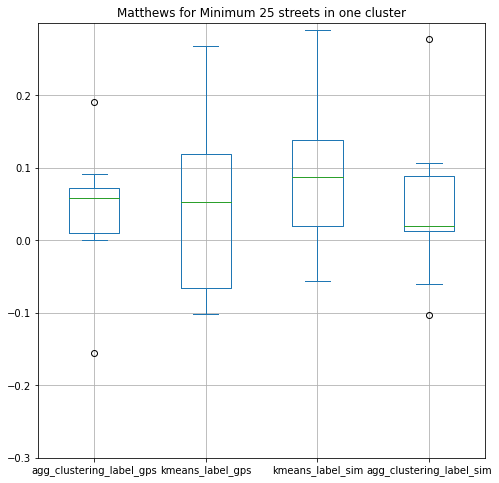

In [47]:
df_matthews.plot.box(
    figsize=(8, 8),
    ylim=(-0.3, 0.3),
    grid=True,
    yticks=(np.arange(-0.3, 0.3, step=0.1)),
    title="Matthews for Minimum 25 streets in one cluster",
)

**As we see from the boxplot above, that our clustering algorithm cannot really beat the baseline and next step we wish to investigate the feature importance and why it is the case that it cannot outperform baseline**

### 6.2 Analyze Why clustering method is worse than baseline

#### Is it because dataset is too small?

by correlating the matthew and train cluster size

In [48]:
pprint.pprint(area_result_matthew_size_corr)

{'Ballard': {'agg_clustering_label_gps': {-1: {'matthew': -0.15566216498466293,
                                               'train_cluster_size': 334}},
             'agg_clustering_label_sim': {-1: {'matthew': -0.1031116067019523,
                                               'train_cluster_size': 468}},
             'kmeans_label_gps': {-1: {'matthew': -0.10205325721637934,
                                       'train_cluster_size': 271}},
             'kmeans_label_sim': {-1: {'matthew': -0.03826839441599791,
                                       'train_cluster_size': 611}}},
 'Chinatown/ID': {'agg_clustering_label_gps': {-1: {'matthew': 0.19058390070527037,
                                                    'train_cluster_size': 266}},
                  'agg_clustering_label_sim': {-1: {'matthew': 0.02034099204642973,
                                                    'train_cluster_size': 340}},
                  'kmeans_label_gps': {-1: {'matthew': 0.19058390070527037,
  

For the best performing clustering algorithm, we plot the correlation between the training data size and the matthew score on the test cluster in scatter plot

In [49]:
dict_matthews = df_matthews.mean(axis=0).to_dict()
# get the algorithm name which gives avg best matthews
best_algo = [
    algo
    for algo, value in dict_matthews.items()
    if value == df_matthews.mean(axis=0).max()
]
# best_algo = ['kmeans_label_sim']
print(f"The algorithm which gives the best Matthew is {best_algo}")

The algorithm which gives the best Matthew is ['kmeans_label_sim']


In [50]:
# get the correlation
best_algo_matthew_size_corr = []
for area, data in area_result_matthew_size_corr.items():
    for algor, values in data.items():
        if algor == best_algo[0]:
            for test_cluster_no, value in values.items():
                best_algo_matthew_size_corr.append(value)

In [51]:
df_best_algo_corr = pd.DataFrame(best_algo_matthew_size_corr)

<AxesSubplot:title={'center':'Correlation between Matthew Score of Test Cluster and the Size of Its Train Cluster For Best Algorithm'}, xlabel='train_cluster_size', ylabel='matthew'>

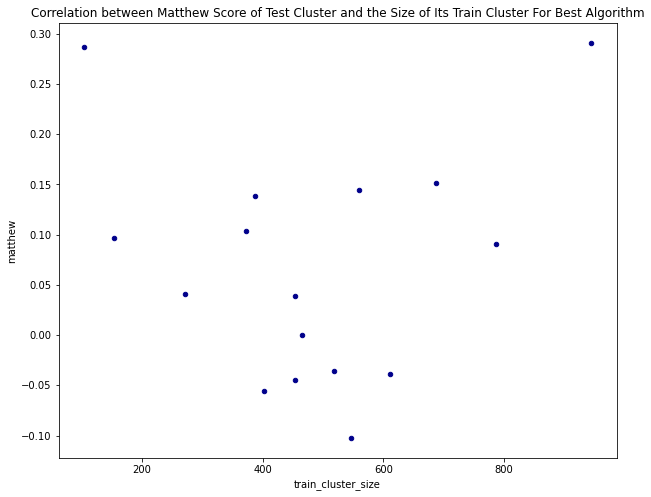

In [52]:
df_best_algo_corr.plot.scatter(
    x="train_cluster_size",
    y="matthew",
    c="DarkBlue",
    figsize=(10, 8),
    title=(
        "Correlation between Matthew Score of Test Cluster and the Size of Its Train "
        "Cluster For Best Algorithm"
    ),
)

**As we observe from the above plot, we could see that there is a positive correlation between the number of data points in the training cluster, and the mathew score on its matched test cluster.**

In [53]:
best_algo

['kmeans_label_sim']

In [54]:
pprint.pprint(area_result_matthew_overfit)

{'Ballard': {'agg_clustering_label_gps': {-1: {'test_cluster_matthew': -0.15566216498466293,
                                               'train_cluster_matthew': 0.7678633874349904,
                                               'train_cluster_matthew_80': 0.7958759932462532,
                                               'valid_cluster_matthew_20': 0.39500925166969103}},
             'agg_clustering_label_sim': {-1: {'test_cluster_matthew': -0.1031116067019523,
                                               'train_cluster_matthew': 0.8617166375622536,
                                               'train_cluster_matthew_80': 0.8752123736926569,
                                               'valid_cluster_matthew_20': 0.6727102391612596}},
             'kmeans_label_gps': {-1: {'test_cluster_matthew': -0.10205325721637934,
                                       'train_cluster_matthew': 0.7928302635538802,
                                       'train_cluster_matthew_80': 0.80151728

In [55]:
best_algo_matthew_overfit = []
for area, data in area_result_matthew_overfit.items():
    for algor, values in data.items():
        if algor == best_algo[0]:
            for label, value in values.items():
                best_algo_matthew_overfit.append(value)

In [56]:
df_best_algo_matthew_overfit = pd.DataFrame(best_algo_matthew_overfit)

In [57]:
df_best_algo_matthew_overfit

,train_cluster_matthew_80,valid_cluster_matthew_20,train_cluster_matthew,test_cluster_matthew
0,0.827966,0.545398,0.805449,0.138322
1,0.785225,0.435835,0.699619,-0.035512
2,0.794752,0.674239,0.879668,0.038575
3,0.768937,0.545416,0.751467,0.144551
4,0.794752,0.674239,0.879668,-0.044414
5,0.714849,0.562069,0.728646,0.151725
6,0.666945,0.766965,0.702607,0.286701
7,0.439769,0.000000,0.507506,0.096850
8,0.758088,0.504299,0.765312,0.103363
9,0.774199,0.567803,0.758469,0.290893


<AxesSubplot:title={'center':'Overfiting with in Training Data and Between Train and Test'}, xlabel='Clusters', ylabel='Matthew'>

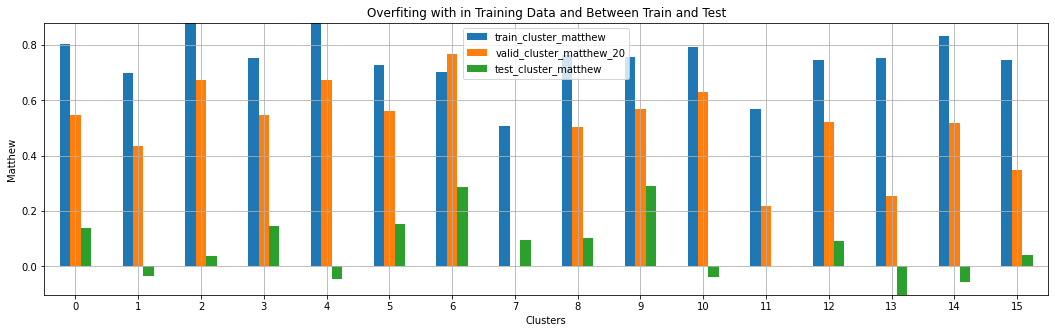

In [58]:
ylim = (
    df_best_algo_matthew_overfit.to_numpy().min(),
    df_best_algo_matthew_overfit.to_numpy().max(),
)
df_best_algo_matthew_overfit[
    ["train_cluster_matthew", "valid_cluster_matthew_20", "test_cluster_matthew"]
].plot.bar(
    rot=0,
    figsize=(18, 5),
    grid=True,
    ylim=ylim,
    title="Overfiting with in Training Data and Between Train and Test",
    xlabel="Clusters",
    ylabel="Matthew",
)

In [59]:
within_train = df_best_algo_matthew_overfit[
    ["train_cluster_matthew_80", "valid_cluster_matthew_20"]
]
train_test = df_best_algo_matthew_overfit[
    ["train_cluster_matthew", "test_cluster_matthew"]
]

#### How badly does the algorithm overfit within the training data?

by analyzing Matthew of model by spliting the training cluster into 80% train, 20% valid

overfitting within the train, as we splited train and valid, and they are in the same domain, if there is overfitting effect, then we could conclude that the algorithm works but due to overfit that it cannot demonstrate its ability.

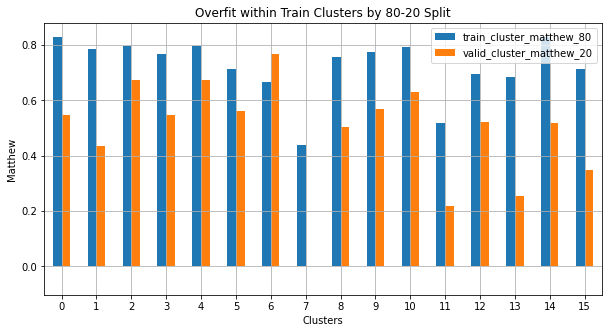

In [60]:
axes_within_train = within_train.plot.bar(
    rot=0,
    figsize=(10, 5),
    ylim=ylim,
    title="Overfit within Train Clusters by 80-20 Split",
    grid=True,
    xlabel="Clusters",
    ylabel="Matthew",
)

#### How badly does the algorithm overfit?

by analyzing Matthew of model on training cluster and test cluster

Here for the best clustering algorithm, we plot analysize the over fit from train to test clusters which includes overfit + domain shift between the train and test

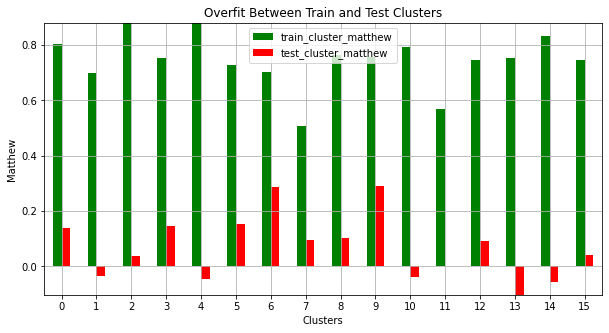

In [61]:
axes_train_test = train_test.plot.bar(
    rot=0,
    figsize=(10, 5),
    ylim=ylim,
    title="Overfit Between Train and Test Clusters",
    grid=True,
    xlabel="Clusters",
    ylabel="Matthew",
    color=["green", "red"],
)

**As we could conclude from above that there is a very severe overfitting when it comes to the train to test model transfer and also maybe domain shift, when it comes to within train clusters 80-20 split, the overfitting trend still exists but not so strong, therefore, we could conclude that the clustering approach could solve partially the problem of domain shift and at the same time suffers the problem of overfitting due to the very small dataset we have.**

**As it seems that our clustering approach does not solve the problem of domain shift compeletely, we would like to investigate other approaches which could 1) overcome the problem of small data set and 2) also align the distribution bettween when it comes to model transfer. Therefore, we will investigate domain adaptation approaches in the other notebook**

### 6.3 Feature Importance

for the best performing clustering algorithm, here we analyse the feature importance of per cluster for different target areas

In [62]:
area_result_feature_importance["Greenlake"]["agg_clustering_label_gps"][-1]

,Feature Id,Importances
0,hour,17.517362
1,highway,13.844057
2,current_capacity,10.921762
3,windspeedKmph,9.109970
4,length,8.641986
5,tempC,5.021744
6,commercial_100,4.981220
7,off_street_capa_100,3.860733
8,shopping_here_100,3.747204
9,supermarket_here_100,3.647799


In [63]:
best_algo_feature_importance = []

for area, data in area_result_feature_importance.items():
    for algo, values in data.items():
        if algo == best_algo[0]:
            for label, value in values.items():
                best_algo_feature_importance.append(value)

In [64]:
best_algo_feature_importance[8]

,Feature Id,Importances
0,hour,14.557865
1,off_street_capa_100,10.559410
2,weekday,9.596394
3,highway,9.433138
4,tempC,8.888815
5,windspeedKmph,7.524691
6,num_off_street_parking_100,6.589205
7,residential_100,6.162634
8,current_capacity,4.844548
9,length,4.751272


In [65]:
for df in best_algo_feature_importance:
    if df.index.name != "Feature Id":
        df.set_index("Feature Id", inplace=True)

In [66]:
df_best_algo_feat_importance = pd.concat(best_algo_feature_importance, axis=1)

In [67]:
df_best_algo_feat_importance

,Importances,Importances,Importances,Importances,Importances,Importances,Importances,Importances,Importances,Importances,Importances,Importances,Importances,Importances,Importances,Importances
Feature Id,,,,,,,,,,,,,,,,
off_street_capa_100,12.065394,5.793230,6.959360,7.712118,6.959360,7.350949,2.797804,3.306007,10.559410,8.292198,4.800952,5.769368,8.155765,3.822476,7.988856,5.689235
hour,11.633217,15.108171,11.497519,11.326609,11.497519,10.974831,17.435307,15.114839,14.557865,8.832304,7.929044,11.689305,8.972123,10.317811,12.824921,15.018500
highway,9.001700,9.286839,6.968824,15.256291,6.968824,13.994733,17.140344,12.042578,9.433138,8.629877,9.881910,9.889977,10.722574,10.240810,9.526398,12.223896
eventsites_100,7.351146,0.537516,4.537509,0.214730,4.537509,0.988302,3.553425,2.039644,0.000000,0.228696,0.414304,0.024600,0.176554,0.149505,0.171046,0.000000
office_here_100,6.279724,1.539636,3.875610,0.680900,3.875610,3.478139,0.680637,2.521876,0.728118,6.282147,1.444295,1.022558,3.766513,3.045416,1.744123,6.336834
transportation_here_100,6.045760,1.985036,2.406875,3.111156,2.406875,2.609209,0.535508,2.152703,2.663306,3.075145,5.163203,4.863718,2.686314,3.338283,5.206895,2.285736
weekday,5.439159,8.284360,7.440678,11.257812,7.440678,10.423168,16.726687,11.458599,9.596394,9.614251,19.926406,8.778336,7.697600,6.705779,9.250595,10.050977
length,4.814282,5.678544,4.295392,5.647104,4.295392,4.758335,3.295246,8.026798,4.751272,7.262104,6.125942,4.635827,5.839206,6.795869,5.567668,5.107767
windspeedKmph,4.557097,6.471020,4.083123,7.524907,4.083123,7.076976,12.659663,11.029859,7.524691,6.035402,5.407088,7.208545,6.304916,6.077091,7.423357,6.363093


In [68]:
print(f"We have used {len(df_best_algo_feat_importance)} features to train our model")

We have used 21 features to train our model


<AxesSubplot:title={'center':'Feature Importance by Test Cluster'}>

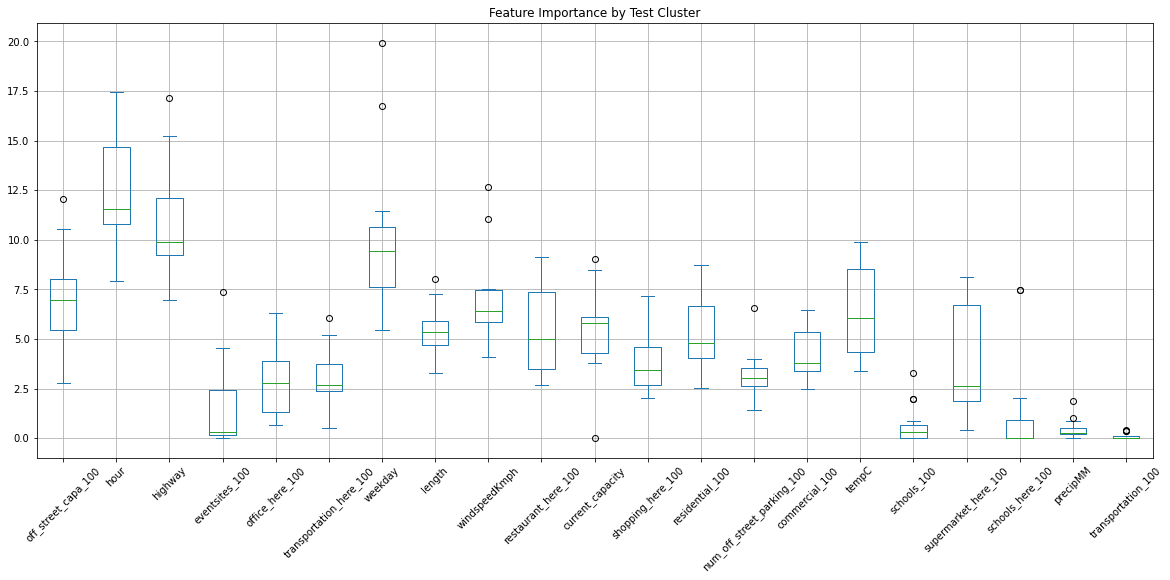

In [69]:
df_best_algo_feat_importance.T.plot.box(
    figsize=(20, 8), grid=True, title="Feature Importance by Test Cluster", rot=45
)

**Here we have ignored for different areas, and plot the feature importance on all the test clusters regardless of the area, and test cluster label, we could see that hour and highway, and off-street capacity are two features of importance whereas transportation_100 counts has the lest feature importance**